# New York taxis trips

This homework is about New York taxi trips. Here is something from [Todd Schneider](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/):

> The New York City Taxi & Limousine Commission has released a  detailed historical dataset covering over 1 billion individual taxi trips in the city from January 2009 through December 2019. 
Taken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it's a story of a City. 
How bad is the rush hour traffic from Midtown to JFK? 
Where does the Bridge and Tunnel crowd hang out on Saturday nights?
What time do investment bankers get to work? How has Uber changed the landscape for taxis?
The dataset addresses all of these questions and many more.

The NY taxi trips dataset has been plowed by series of distinguished data scientists.
The dataset is available from on Amazon S3 (Amazon's cloud storage service).
The link for each file has the following form:

    https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv

There is one CSV file for each NY taxi service (`yellow`, `green`, `fhv`) and each calendar month (replacing `{year}` and `{month}` by the desired ones).
Each file is moderately large, a few gigabytes. 
The full dataset is relatively large if it has to be handled on a laptop (several hundred gigabytes).

You will focus on the `yellow` taxi service and a pair of months, from year 2015 and from year 2018. 
Between those two years, for hire vehicles services have taken off and carved a huge marketshare.

Whatever the framework you use, `CSV` files prove hard to handle. 
After downloading the appropriate files (this takes time, but this is routine), a first step will consist in converting the csv files into a more Spark friendly format such as `parquet`.

Saving into one of those formats require decisions about bucketing, partitioning and so on. Such decisions influence performance. It is your call.
Many people have been working on this dataset, to cite but a few:


- [1 billion trips with a vengeance](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/)
- [1 billion trips with R and SQL ](http://freerangestats.info/blog/2019/12/22/nyc-taxis-sql)
- [1 billion trips with redshift](https://tech.marksblogg.com/billion-nyc-taxi-rides-redshift.html)
- [nyc-taxi](https://github.com/fmaletski/nyc-taxi-map)

Depending on your internet connection, **download the files** corresponding to **"yellow" taxis** for the years 2015 and 2018. Download **at least one month** (the same) for 2015 and 2018, if you can download all of them.

**Hint.** The 12 csv for 2015 are about 23GB in total, but the corresponding parquet file, if you can create it for all 12 months, is only about 3GB.

You **might** need the following stuff in order to work with GPS coordinates and to plot things easily.

In [1]:
!pip install geojson geopandas plotly geopy

     |████████████████████████████████| 928 kB 527 kB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 969 kB/s eta 0:00:01
     |████████████████████████████████| 113 kB 508 kB/s eta 0:00:01
     |████████████████████████████████| 14.7 MB 73 kB/s  eta 0:00:01
     |████████████████████████████████| 10.9 MB 627 kB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 3.0 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=9530 sha256=ebf6550d13108f968cc5c98af6338c806cf56a9f80814e25a404987c9ff15347
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [147]:
!pip install ipyleaflet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [143]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


For this homework **we will let you decide on the tools to use** (expected for Spark) and to **find out information all by yourself** (but don't hesitate to ask questions on the `slack` channel).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import timeit

%matplotlib inline
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)

In [2]:
# spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count
import pyspark.sql.functions as fn
from pyspark.sql.catalog import Catalog
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType

In [3]:
from ipyleaflet import Map, Heatmap

In [4]:
conf = SparkConf().setAppName("Spark SQL Illustrations")
conf.set('spark.executor.memory', '8g')
conf.set('spark.driver.memory', '4g')
conf.set('spark.sql.shuffle.partitions', 8)
sc = SparkContext(conf=conf)

spark = (SparkSession
    .builder
    .appName("Spark SQL")
    .getOrCreate()
)

# Loading data as parquet files

We want to organize the data on a per year and per service basis. 
We want to end up with one `parquet` file for each year and each taxi service, since parquet is much better than CSV files.

**Hint.** Depending on your internet connection and your laptop, you can use only the "yellow" service and use one month of 2015 and 2018

CSV files can contain corrupted lines. You may have to work in order to perform ETL (Extract-Transform-Load) in order obtain a properly typed data frame.

You are invited to proceed as follows:

1. Try to read the CSV file without imposing a schema. 
1. Inspect the inferred schema. Do you agree with Spark's typing decision?
1. Eventually correct the schema and read again the data
1. Save the data into parquet files
1. In the rest of your work, **you will only use the parquet files you created**, not the csv files (don't forget to choose a partitioning column and a number of partitions when creating the parquet files).

**Hint.** Don't forget to ask `Spark` to use all the memory and ressources from your computer.

**Hint.** Don't foreget that you should specify a partitioning column and a number of partitions when creating the parquet files.

**Hint.** Note that the schemas of the 2015 and 2018 data are different...

**Hint.** When working on this, ask you and answer to the following questions:

1. What is the `StorageLevel` of the dataframe after reading the csv files?
1. What is the number of partitions of the dataframe? 
1. Is it possible to tune this number at loading time? 
1. Why would we want to modify the number of partitions when creating the parquet files?

In [3]:
partitionBy('month')import requests
from pathlib import Path

path = Path('data_csv')
if not path.exists():
    os.makedirs(os.path.dirname('./data_csv/'), exist_ok=True)
    for i in (2015, 2018):
        for j in range(1, 13):
            url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_' \
                  + str(i) + '-' + '%.2d' % j + '.csv'
            r = requests.get(url)
            with open('./data_csv'/ + 'yellow_tripdata_'+ str(i) + "-" + '%.2d' % j + '.csv', 'wb') as f:
                f.write(r.content)

In [4]:
df_2015 = spark.read\
               .format('csv')\
               .option("header", "true")\
               .option("mode", "FAILFAST")\
               .option("inferSchema", "true")\
               .option("sep", ",")\
               .load("./data_csv/*2015*.csv")

df_2015.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



In [5]:
print(df_2015.rdd.getStorageLevel())

Serialized 1x Replicated


In [6]:
df_2015.rdd.getNumPartitions()

173

**Store_and_fwd_flag** : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  
Y= store and forward trip  
N= not a store and forward trip  
[*Source*](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)  
  
So, we decided to make its column as a boolean; as there are only two valid values, indicating if there is a property or not.  
Deciding about the casting types of the other columns is quite straightforward.

In [7]:
for e in ('VendorID', 'passenger_count', 'RatecodeID', 'payment_type'):
    df_2015 = df_2015.withColumn(e, df_2015[e].cast('int'))

for e in ('trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
          'dropoff_latitude', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
          'improvement_surcharge', 'total_amount'):
    df_2015 = df_2015.withColumn(e, df_2015[e].cast('double'))
    
df_2015 = df_2015.withColumn('tpep_pickup_datetime', df_2015.tpep_pickup_datetime.cast('timestamp'))
df_2015 = df_2015.withColumn('tpep_dropoff_datetime', df_2015.tpep_dropoff_datetime.cast('timestamp'))
df_2015 = df_2015.withColumn('store_and_fwd_flag', 
                            fn.when(
                                fn.col('store_and_fwd_flag') == 'N',
                                    'False'
                            ).when(
                                fn.col('store_and_fwd_flag') == 'Y',
                                    'True'
                            ).otherwise(None))
df_2015 = df_2015.withColumn('store_and_fwd_flag', df_2015.store_and_fwd_flag.cast('boolean'))

df_2015.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



To export, we tried various partitioning/repartioning strategies to find one which would make the queries more efficient: adding other columns, giving different numbers of repartitions...  
It turned out that doing it simply by the month is generally the most efficient way.

In [17]:
df_2015.withColumn('month', fn.month(col('tpep_pickup_datetime'))) \
       .repartition('month') \
       .write.mode('overwrite') \
       .partitionBy('month') \
       .parquet('./data_parquet/yellow_tripdata_2015.parquet')

In [4]:
df_2018 = spark.read\
               .format('csv')\
               .option("header", "true")\
               .option("mode", "FAILFAST")\
               .option("inferSchema", "true")\
               .option("sep", ",")\
               .load("./data_csv/*2018*.csv")

df_2018.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [5]:
print(df_2018.storageLevel)

Serialized 1x Replicated


In [6]:
df_2018.rdd.getNumPartitions()

69

In [7]:
df_2018 = df_2018.withColumn('store_and_fwd_flag', 
                            fn.when(
                                fn.col('store_and_fwd_flag') == 'N',
                                    'False'
                            ).when(
                                fn.col('store_and_fwd_flag') == 'Y',
                                    'True'
                            ).otherwise(None))
df_2018 = df_2018.withColumn('store_and_fwd_flag', df_2018.store_and_fwd_flag.cast('boolean'))

df_2018.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [8]:
df_2018.withColumn('month', fn.month(col('tpep_pickup_datetime'))) \
       .repartition('month') \
       .write.mode('overwrite') \
       .partitionBy('month') \
       .parquet('./data_parquet/yellow_tripdata_2018.parquet')

To tune the number of partitions of the DataFrame at the loading time, we can use for example the coalesce function with the read, indicating the number of desired partitions.  
  
**e.g.** `df = spark.read.csv(...).coalesce(2)` to get two partitions for the DataFrame `df`.

For the parquet files, the number of partitions can make some queries more efficient: if we can separate our data in a way that allows spark to only look at a restricted number of rows among the whole data for our queries, then we gain a lot in performance; that's what a correct partitioning can allow.  
  
**e.g.** For a column with values between 2 and 8, if we are looking for the rows with the value 2 and those rows are in a separate partition, then the query would be much faster than if those rows were in a partition with the values 2, 3, ...  
  
But partitioning is expensive, so such a thing should be done only if similar queries must be done often.

In [5]:
dfp_2015 = spark.read.parquet('./data_parquet/yellow_tripdata_2015.parquet')
dfp_2015 = dfp_2015.drop('month')
dfp_2015.head()

Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2015, 2, 8, 11, 33, 46), tpep_dropoff_datetime=datetime.datetime(2015, 2, 8, 11, 37, 45), passenger_count=1, trip_distance=0.56, pickup_longitude=-73.94990539550781, pickup_latitude=40.717437744140625, RatecodeID=1, store_and_fwd_flag=False, dropoff_longitude=-73.95001220703125, dropoff_latitude=40.7240104675293, payment_type=1, fare_amount=4.5, extra=0.0, mta_tax=0.5, tip_amount=1.06, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=6.36)

In [6]:
dfp_2018 = spark.read.parquet('./data_parquet/yellow_tripdata_2018.parquet')
dfp_2018 = dfp_2018.drop('month')
dfp_2018.head()

Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2019, 6, 28, 13, 0, 8), tpep_dropoff_datetime=datetime.datetime(2019, 6, 28, 13, 7, 3), passenger_count=1, trip_distance=0.85, RatecodeID=1, store_and_fwd_flag=False, PULocationID=140, DOLocationID=237, payment_type=1, fare_amount=6.5, extra=1.0, mta_tax=0.5, tip_amount=1.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=9.3)

# Investigate (at least) one month of data in 2015

From now on, you will be using **the parquet files you created for 2015**.

We shall visualize several features of taxi traffic during one calendar month
in 2015 and the same calendar month in 2018.

**Hint.** In order to build appealing graphics, you may stick to `matplotlib + seaborn`, you can use also
`plotly`, which is used a lot to build interactive graphics, but you can use whatever you want.

The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattan and Verazzano bridge.

In [7]:
long_min = -74.10
long_max = -73.70
lat_min = 40.58
lat_max = 40.90

1. Using these boundaries, **filter the 2015 data** (using pickup and dropoff longitude and latitude) and count the number of trips for each value of `passenger_count` and make a plot of that.

In [9]:
res = dfp_2015.select('passenger_count','pickup_longitude','pickup_latitude',
                     'dropoff_longitude','dropoff_latitude') \
              .filter(fn.month(col('tpep_pickup_datetime')) == 1) \
              .filter(col('pickup_longitude').between(long_min, long_max) &\
                      col('dropoff_longitude').between(long_min, long_max) &\
                      col('pickup_latitude').between(lat_min, lat_max) &\
                      col('dropoff_latitude').between(lat_min, lat_max)) \
              .groupBy('passenger_count').count()
        
res.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              6| 449957|
|              9|      6|
|              5| 690435|
|              1|8766040|
|              3| 517555|
|              7|      7|
|              2|1772672|
|              4| 247628|
|              0|   6108|
|              8|      7|
+---------------+-------+



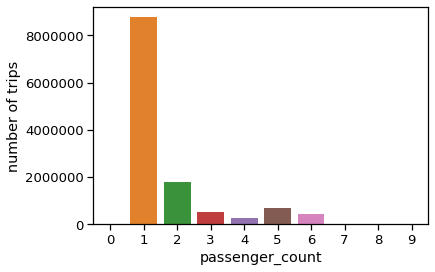

In [10]:
sns.barplot(x='passenger_count', y='count', data=res.toPandas())
plt.ylabel('number of trips')
plt.show()

Trips with $0$ or larger than $7$ passengers are pretty rare.
We suspect these to be outliers. 
We need to explore these trips further in order order to understand what might be wrong
with them

1. What's special with trips with zero passengers?
1. What's special with trips with more than $6$ passengers?
1. What is the largest distance travelled during this month? Is it the first taxi on the moon?
1. Plot the distribution of the `trip_distance` (using an histogram for instance) during year 2105. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

In [8]:
dfp_2015_01 = dfp_2015.where(fn.month(col('tpep_pickup_datetime')) == 1)

In [12]:
dfp_2015_01.select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'payment_type', 
                   'fare_amount', 'extra', 'tip_amount', 'total_amount')\
           .where('passenger_count == 0').show()

+--------------------+---------------------+-------------+------------+-----------+-----+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|payment_type|fare_amount|extra|tip_amount|total_amount|
+--------------------+---------------------+-------------+------------+-----------+-----+----------+------------+
| 2015-01-16 05:48:13|  2015-01-16 05:59:05|          2.3|           2|       10.0|  0.5|       0.0|        11.3|
| 2015-01-14 10:36:24|  2015-01-14 10:42:53|          1.3|           1|        6.5|  0.0|      1.45|        8.75|
| 2015-01-26 13:55:39|  2015-01-26 13:58:54|          0.4|           2|        4.0|  0.0|       0.0|         4.8|
| 2015-01-23 18:09:36|  2015-01-23 18:19:05|          1.3|           1|        8.0|  1.0|      1.95|       11.75|
| 2015-01-26 20:01:10|  2015-01-26 20:07:44|          1.2|           2|        6.5|  1.0|       0.0|         8.3|
| 2015-01-13 12:51:19|  2015-01-13 13:12:56|          1.2|           1|       13.5|  0.0

Even though there are supposedly no passengers, there are still fares recorded, with tip amounts.  
More over, the times seem to be rather consistent with the trip distances and different payment types were recorded.  
So, we can suppose it is rather about wrong recordings of the passenger number than about accidental addings of the records.  
~*But shorter trips are sometimes more expensive than the longer ones for some reason...*~

In [13]:
dfp_2015_01.select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'payment_type', 
                   'fare_amount', 'extra', 'tip_amount', 'total_amount')\
           .where('passenger_count > 6').show()

+--------------------+---------------------+-------------+------------+-----------+-----+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|payment_type|fare_amount|extra|tip_amount|total_amount|
+--------------------+---------------------+-------------+------------+-----------+-----+----------+------------+
| 2015-01-02 20:14:40|  2015-01-02 20:14:44|          0.0|           1|        9.8|  0.0|       0.0|        10.6|
| 2015-01-04 17:50:19|  2015-01-04 18:07:42|          3.2|           1|       14.5|  0.0|      3.05|       18.35|
| 2015-01-18 02:19:59|  2015-01-18 02:20:01|          0.0|           1|        8.8|  0.0|      2.64|       12.24|
| 2015-01-29 01:52:23|  2015-01-29 01:52:37|          0.0|           1|        8.0|  0.0|       1.6|        10.4|
| 2015-01-21 19:54:43|  2015-01-21 20:04:06|          1.3|           1|        7.5|  1.0|      1.85|       11.15|
| 2015-01-06 14:55:07|  2015-01-06 15:36:04|        24.33|           2|       96.0|  0.0

Surprisingly, there are plenty of 0.0 trip distances with more than six passengers recorded.  
Most of the total amounts are consistent with the trip distances, though there is a 5.93 distance that cost 108.3...

In [14]:
dfp_2015_01.agg(fn.max('trip_distance')).first()[0]

15420004.5

The distance between the moon and the earth is around 240,000 mi, so one might even say it went past the moon !

In [15]:
tp = dfp_2015_01.select('trip_distance')\
                .filter('trip_distance != 0 and trip_distance < 30')\
                .groupBy('trip_distance').count()\
                .sort('trip_distance')
tp.show()

+-------------+-----+
|trip_distance|count|
+-------------+-----+
|         0.01| 3007|
|         0.02| 2266|
|         0.03| 1947|
|         0.04| 1615|
|         0.05| 1429|
|         0.06| 1195|
|         0.07| 1068|
|         0.08| 1042|
|         0.09| 1068|
|          0.1|13781|
|         0.11|  923|
|         0.12| 1017|
|         0.13| 1090|
|         0.14| 1164|
|         0.15| 1221|
|         0.16| 1206|
|         0.17| 1350|
|         0.18| 1494|
|         0.19| 1652|
|          0.2|29523|
+-------------+-----+
only showing top 20 rows



In [16]:
tppd = tp.toPandas()
tppd.head()

,trip_distance,count
0,0.01,3007
1,0.02,2266
2,0.03,1947
3,0.04,1615
4,0.05,1429


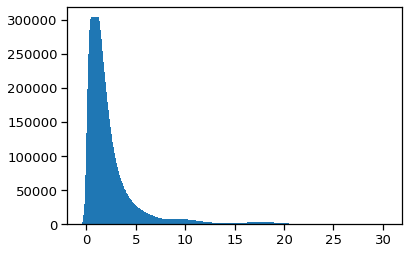

In [17]:
plt.bar(tppd['trip_distance'], tppd['count'])
plt.show()

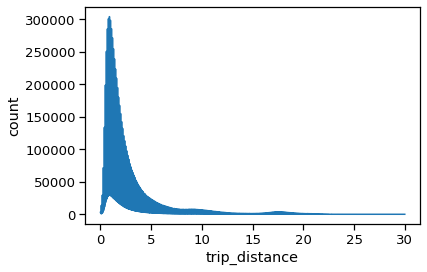

In [18]:
sns.lineplot(x='trip_distance', y='count', data=tppd)
plt.show()

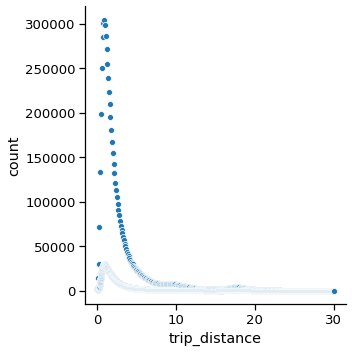

In [19]:
sns.relplot(x='trip_distance', y='count', data=tppd)
plt.show()

So most of the trip distances are between 0 and 5, but there are yet values between 0 and 5 that are not numerous.

Let's look at what Spark does for these computations

1. Use the `explain` method or have a look at the [Spark UI](http://localhost:4040/SQL/) to analyze the job. You should be able to assess 
    - Parsed Logical Plan
    - Analyzed Logical Plan
    - Optimized Logical Plan
    - Physical Plan
1. Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any. How would a RDBMS proceed with such a query?
1. How does the physical plan differ from the Optimized Logical Plan? What are the keywords you would not expects in a RDBMS? What is their meaning? 
1. Inspect the stages on [Spark UI](http://localhost:4040/stages/stage). How many *stages* are necessary to complete the Spark job? What are the roles of `HashAggregate` and `Exchange hashpartitioning`?
1. Does the physical plan perform `shuffle` operations? If yes how many?
1. What are tasks with respect to stages (in Spark language)? How many tasks are your stages made of?

In [20]:
res.explain(True)

== Parsed Logical Plan ==
'Aggregate ['passenger_count], [unresolvedalias('passenger_count, None), count(1) AS count#123L]
+- Filter (((((pickup_longitude#5 >= -74.1) && (pickup_longitude#5 <= -73.7)) && ((dropoff_longitude#9 >= -74.1) && (dropoff_longitude#9 <= -73.7))) && ((pickup_latitude#6 >= 40.58) && (pickup_latitude#6 <= 40.9))) && ((dropoff_latitude#10 >= 40.58) && (dropoff_latitude#10 <= 40.9)))
   +- Project [passenger_count#3, pickup_longitude#5, pickup_latitude#6, dropoff_longitude#9, dropoff_latitude#10]
      +- Filter (month(cast(tpep_pickup_datetime#1 as date)) = 1)
         +- Project [passenger_count#3, pickup_longitude#5, pickup_latitude#6, dropoff_longitude#9, dropoff_latitude#10, tpep_pickup_datetime#1]
            +- Project [VendorID#0, tpep_pickup_datetime#1, tpep_dropoff_datetime#2, passenger_count#3, trip_distance#4, pickup_longitude#5, pickup_latitude#6, RatecodeID#7, store_and_fwd_flag#8, dropoff_longitude#9, dropoff_latitude#10, payment_type#11, fare_amount

In [21]:
dfp_2015_01.select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'payment_type', 
                   'fare_amount', 'extra', 'tip_amount', 'total_amount')\
           .where('passenger_count == 0').explain(True)

== Parsed Logical Plan ==
'Filter ('passenger_count = 0)
+- Project [tpep_pickup_datetime#1, tpep_dropoff_datetime#2, trip_distance#4, payment_type#11, fare_amount#12, extra#13, tip_amount#15, total_amount#18]
   +- Filter (month(cast(tpep_pickup_datetime#1 as date)) = 1)
      +- Project [VendorID#0, tpep_pickup_datetime#1, tpep_dropoff_datetime#2, passenger_count#3, trip_distance#4, pickup_longitude#5, pickup_latitude#6, RatecodeID#7, store_and_fwd_flag#8, dropoff_longitude#9, dropoff_latitude#10, payment_type#11, fare_amount#12, extra#13, mta_tax#14, tip_amount#15, tolls_amount#16, improvement_surcharge#17, total_amount#18]
         +- Relation[VendorID#0,tpep_pickup_datetime#1,tpep_dropoff_datetime#2,passenger_count#3,trip_distance#4,pickup_longitude#5,pickup_latitude#6,RatecodeID#7,store_and_fwd_flag#8,dropoff_longitude#9,dropoff_latitude#10,payment_type#11,fare_amount#12,extra#13,mta_tax#14,tip_amount#15,tolls_amount#16,improvement_surcharge#17,total_amount#18,month#19] parquet



In [22]:
dfp_2015_01.select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'payment_type', 
                   'fare_amount', 'extra', 'tip_amount', 'total_amount')\
           .where('passenger_count > 6').explain(True)

== Parsed Logical Plan ==
'Filter ('passenger_count > 6)
+- Project [tpep_pickup_datetime#1, tpep_dropoff_datetime#2, trip_distance#4, payment_type#11, fare_amount#12, extra#13, tip_amount#15, total_amount#18]
   +- Filter (month(cast(tpep_pickup_datetime#1 as date)) = 1)
      +- Project [VendorID#0, tpep_pickup_datetime#1, tpep_dropoff_datetime#2, passenger_count#3, trip_distance#4, pickup_longitude#5, pickup_latitude#6, RatecodeID#7, store_and_fwd_flag#8, dropoff_longitude#9, dropoff_latitude#10, payment_type#11, fare_amount#12, extra#13, mta_tax#14, tip_amount#15, tolls_amount#16, improvement_surcharge#17, total_amount#18]
         +- Relation[VendorID#0,tpep_pickup_datetime#1,tpep_dropoff_datetime#2,passenger_count#3,trip_distance#4,pickup_longitude#5,pickup_latitude#6,RatecodeID#7,store_and_fwd_flag#8,dropoff_longitude#9,dropoff_latitude#10,payment_type#11,fare_amount#12,extra#13,mta_tax#14,tip_amount#15,tolls_amount#16,improvement_surcharge#17,total_amount#18,month#19] parquet



The Optimized Logical Plan is usually shorter than the Analyzed Logical Plan: the first one has only one Project and one Filter &mdash; with one Aggregate before them if the second has it too &mdash; while the second has multiple Projects and Filters in different orders. A RDBMS will rather do as the Analyzed Logical Plan describes.  
Between the Physical Plan and the Optimized Logical Plan, the difference is in the usage of a FileScan instead of a Relation and in the usage of HashAggregate(s) instead of an Aggregate when needed. With a RDBMS, one would not expect a FileScan or a Relation; those are keywords indicating the analysis of the parquet files.  

For `res`, there were 2 stages with 29 tasks (28 + 1) for 1 job.  
For the query with `passenger_count == 0`, there were 3 stages with 25 tasks (1 + 4 + 20) for 3 jobs.  
For the query with `passenger_count > 6`, there were 4 stages with 28 tasks (1 + 4 + 20 + 3) for 4 jobs.  
The `HashAggregate` is used to get a value for a key in a partition, the `ExchangeHashPartitioning` can then be used to regroup the same keys.  

One shuffle operation is made for `res`.  

A stage is a step in the physical execution plan, and a task is assigned to the different partitions involved to get the step done concurrently.

Now, compute the following and produce relevant plots:

1. Break down the trip distance distribution for each day of week
1. Count the number of distinct pickup location
1. Compute and display tips and profits as a function of the pickup location

In [23]:
tddow = dfp_2015_01.withColumn('Day of week', fn.date_format('tpep_pickup_datetime', 'EEEE'))\
                   .groupBy('trip_distance', 'Day of week').count()
tddow.show()

+-------------+-----------+-----+
|trip_distance|Day of week|count|
+-------------+-----------+-----+
|         2.37|   Thursday| 1913|
|         0.96|   Thursday| 5044|
|         6.05|    Tuesday|  144|
|         1.76|   Thursday| 3069|
|         2.23|   Thursday| 2168|
|         2.25|     Sunday| 1629|
|         0.49|     Sunday| 1752|
|         3.72|     Sunday|  664|
|          2.5|     Sunday|13334|
|         7.15|     Friday|  167|
|         3.14|     Sunday|  964|
|         1.03|     Friday| 5001|
|         2.36|     Friday| 1985|
|         2.97|     Friday| 1255|
|          3.0|   Thursday|12226|
|         1.46|     Friday| 3984|
|         2.25|     Friday| 2167|
|         0.85|   Thursday| 4847|
|        18.92|     Friday|   48|
|         5.35|     Friday|  328|
+-------------+-----------+-----+
only showing top 20 rows



In [24]:
tddow.count()

21658

In [25]:
tddowpd = tddow.toPandas()

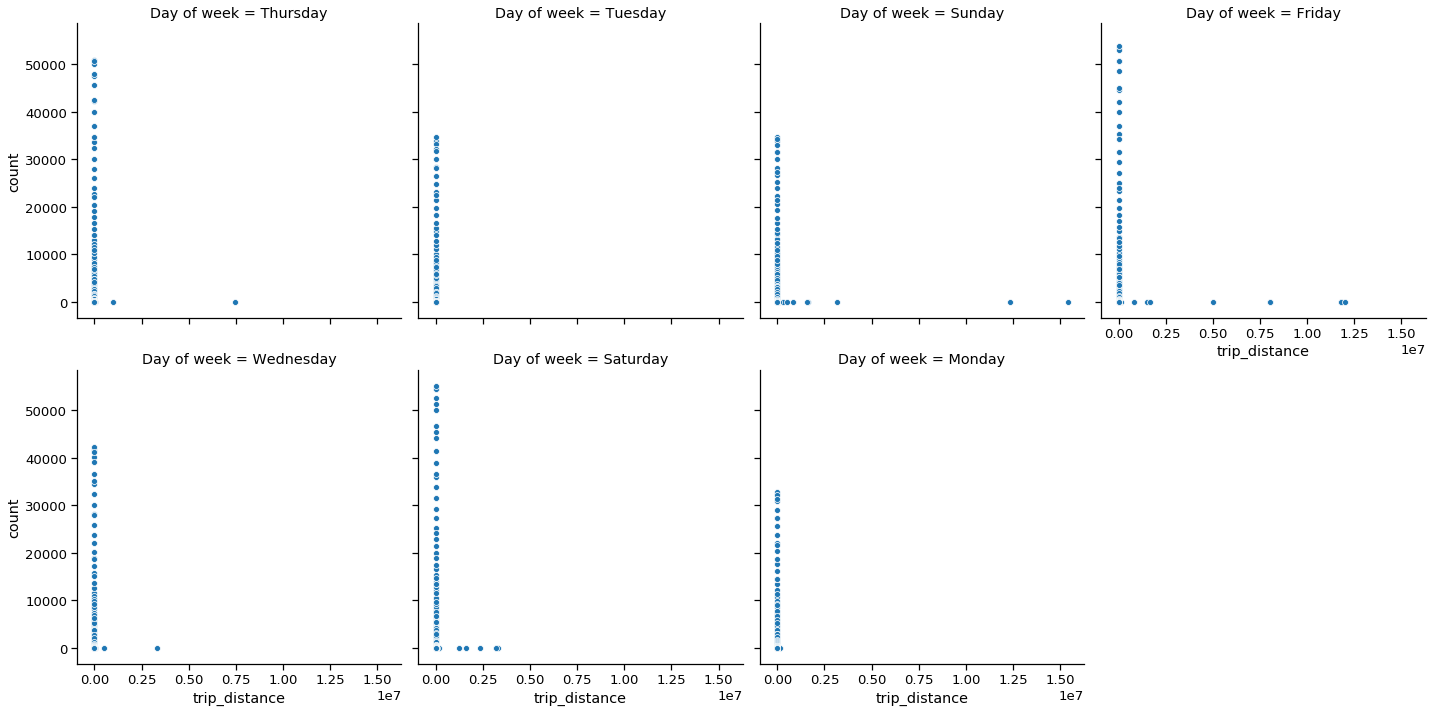

In [26]:
sns.relplot(x='trip_distance', y='count', data=tddowpd, col='Day of week', col_wrap=4)
plt.show()

Let's filter some some trip distances to better see the data.

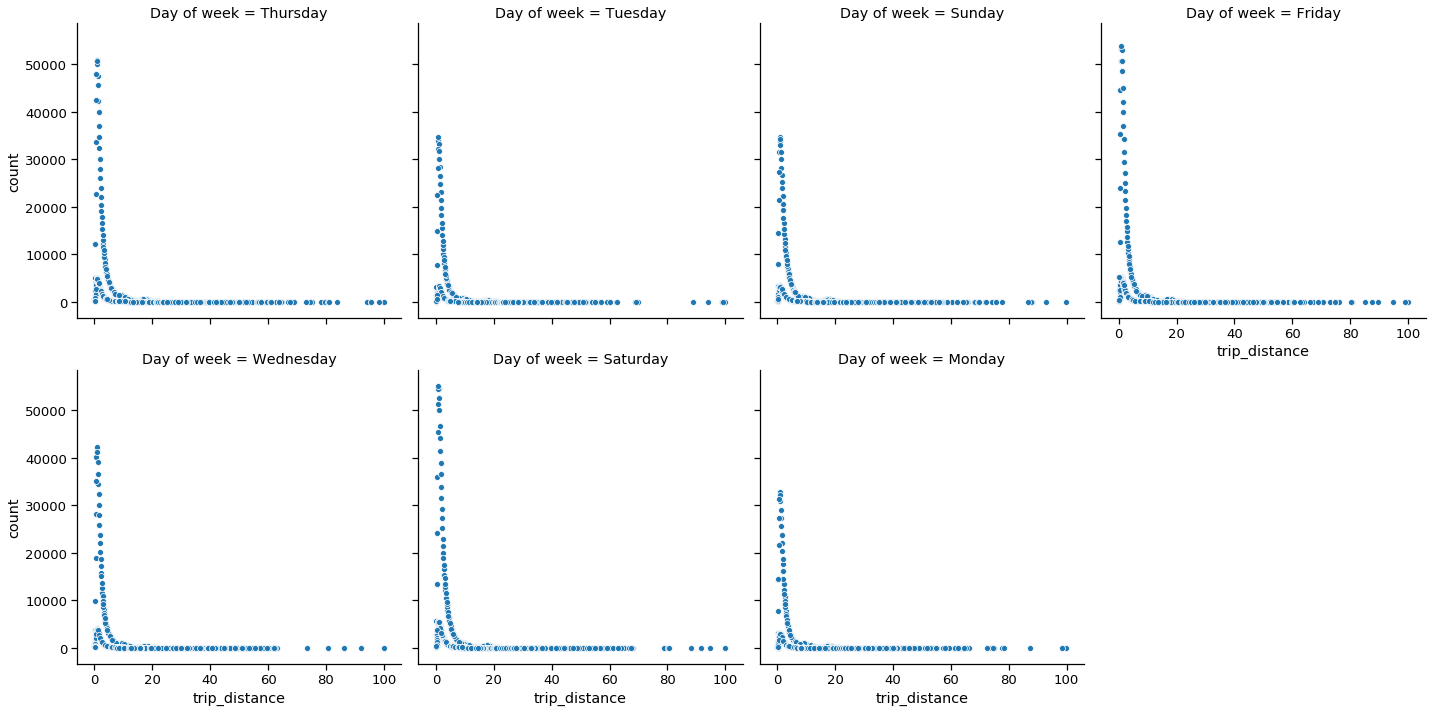

In [27]:
sns.relplot(x='trip_distance', y='count', 
            data=tddowpd[tddowpd.trip_distance.between(0, 100, inclusive=False)], 
            col='Day of week', col_wrap=4)
plt.show()

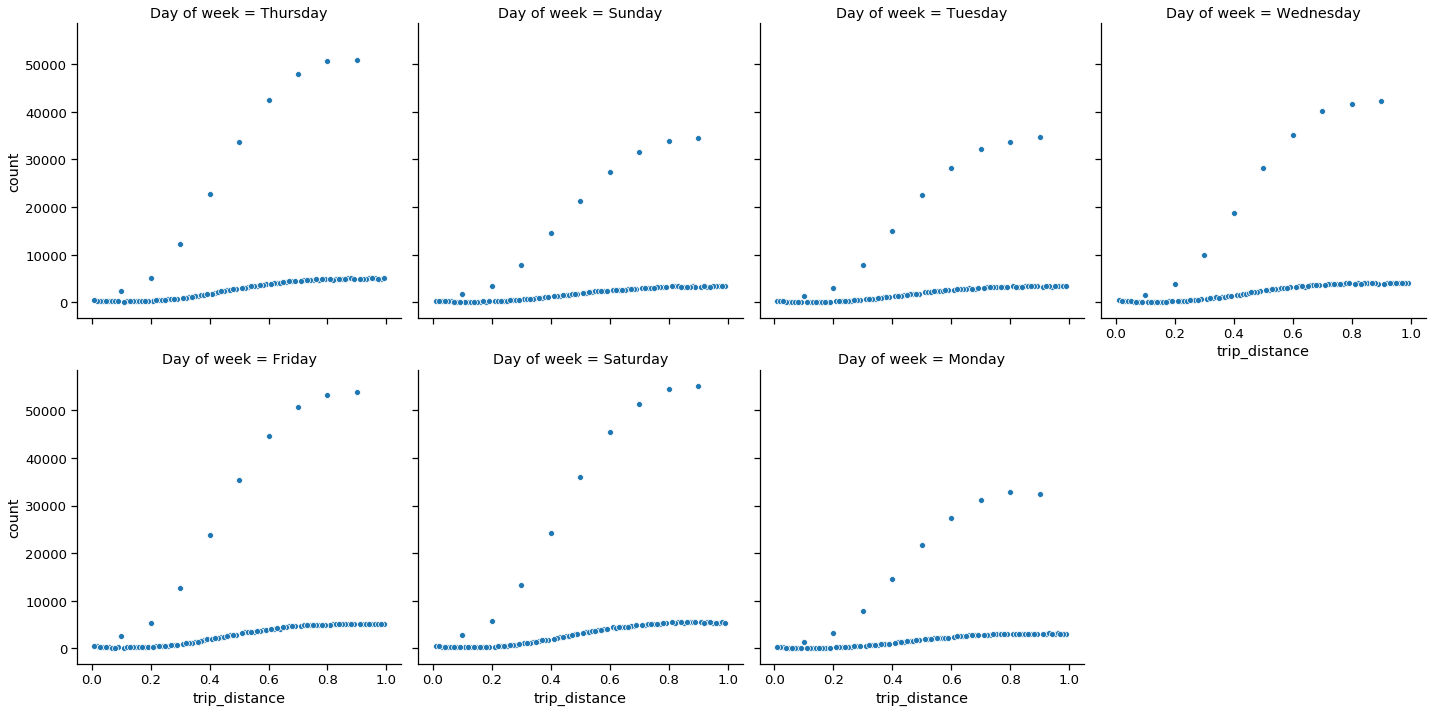

In [28]:
sns.relplot(x='trip_distance', y='count', 
            data=tddowpd[tddowpd.trip_distance.between(0, 1, inclusive=False)], 
            col='Day of week', col_wrap=4)
plt.show()

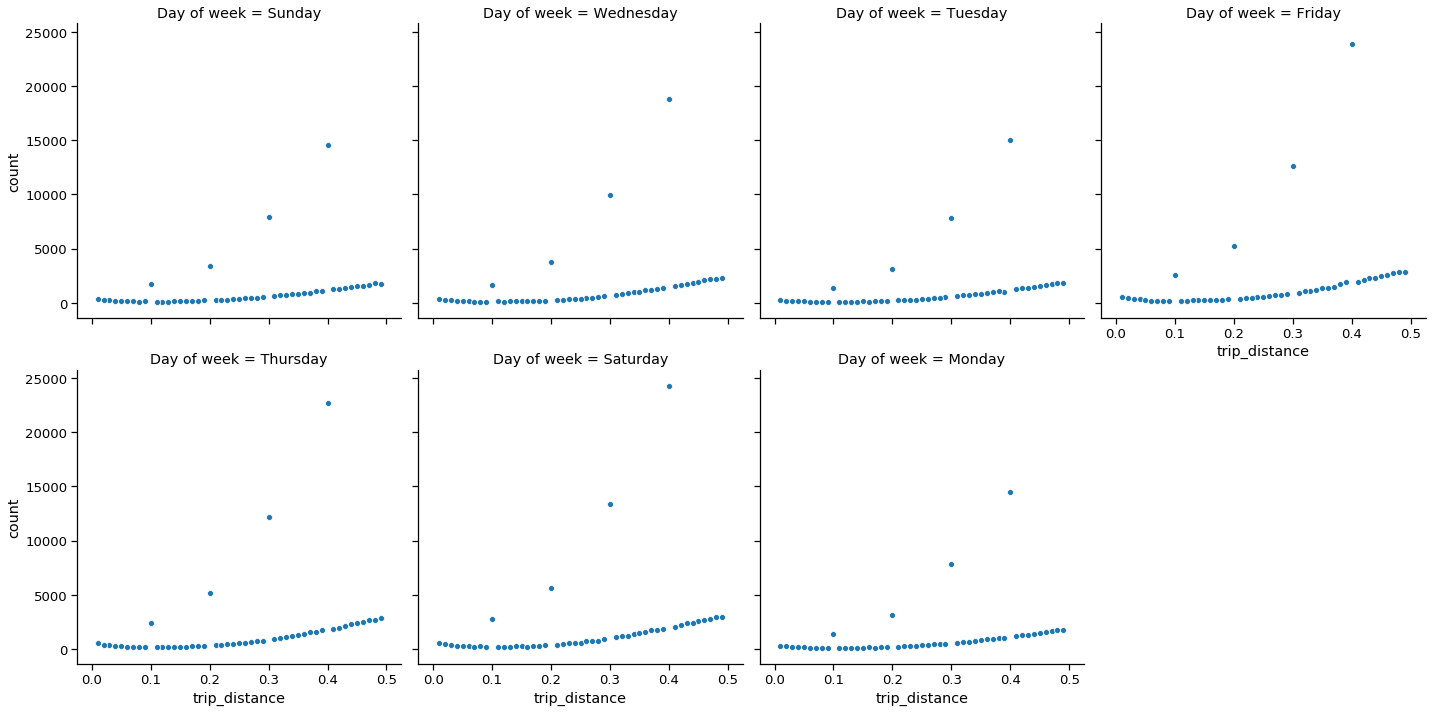

In [29]:
sns.relplot(x='trip_distance', y='count', 
            data=tddowpd[tddowpd.trip_distance.between(0, 0.5, inclusive=False)], 
            col='Day of week', col_wrap=4)
plt.show()

In [30]:
dfp_2015_01.select('pickup_longitude', 'pickup_latitude').distinct().count()

9637633

There are over 9 million distinct locations; we need to shorten them to make them visible in a plot and to make the conversion to Pandas possible.  

So, we decided to round the values for the longitude and the latitude in order to have four digits after the dot &mdash; the number of digits Google gives for a given location.  

But we need to get a single value for the tip and the amount for each rounded coordinate. We decided to use the average for them.

In [31]:
dfp_2015_01_zone = dfp_2015_01.withColumn('pickup_longitude', fn.round('pickup_longitude', 4))\
                              .withColumn('pickup_latitude', fn.round('pickup_latitude', 4))\
                              .groupBy('pickup_longitude','pickup_latitude')\
                              .agg(fn.mean('tip_amount').alias('average_tip'), 
                                   fn.mean('total_amount').alias('average_amount'))
dfp_2015_01_zone.show()

+----------------+---------------+------------------+------------------+
|pickup_longitude|pickup_latitude|       average_tip|    average_amount|
+----------------+---------------+------------------+------------------+
|        -73.9682|        40.7554|1.3973770491803277|12.754163934426236|
|        -73.9926|         40.733|             2.475| 16.69666666666667|
|        -73.9833|         40.726|1.6858659217877094|13.421620111731837|
|        -73.9644|        40.7648|0.9564224137931034| 10.30379310344827|
|        -73.9663|        40.7898|  1.14135593220339| 10.17864406779661|
|        -73.9822|        40.7708|1.2094444444444443|12.403456790123451|
|        -74.0028|        40.7179|               1.5|             19.55|
|        -73.9973|         40.684|2.2950000000000004|17.416428571428572|
|        -73.7866|        40.6441|3.9814285714285718|             61.35|
|         -73.976|        40.7528|1.6059090909090907|13.178636363636365|
|         -73.982|        40.7364|1.340948905109489

In [32]:
dfp_2015_01_zone.count()

431513

In [33]:
dfp_2015_01_zone_pd = dfp_2015_01_zone.toPandas()
dfp_2015_01_zone_pd.head()

,pickup_longitude,pickup_latitude,average_tip,average_amount
0,-73.9682,40.7554,1.397377,12.754164
1,-73.9926,40.7330,2.475000,16.696667
2,-73.9833,40.7260,1.685866,13.421620
3,-73.9644,40.7648,0.956422,10.303793
4,-73.9663,40.7898,1.141356,10.178644


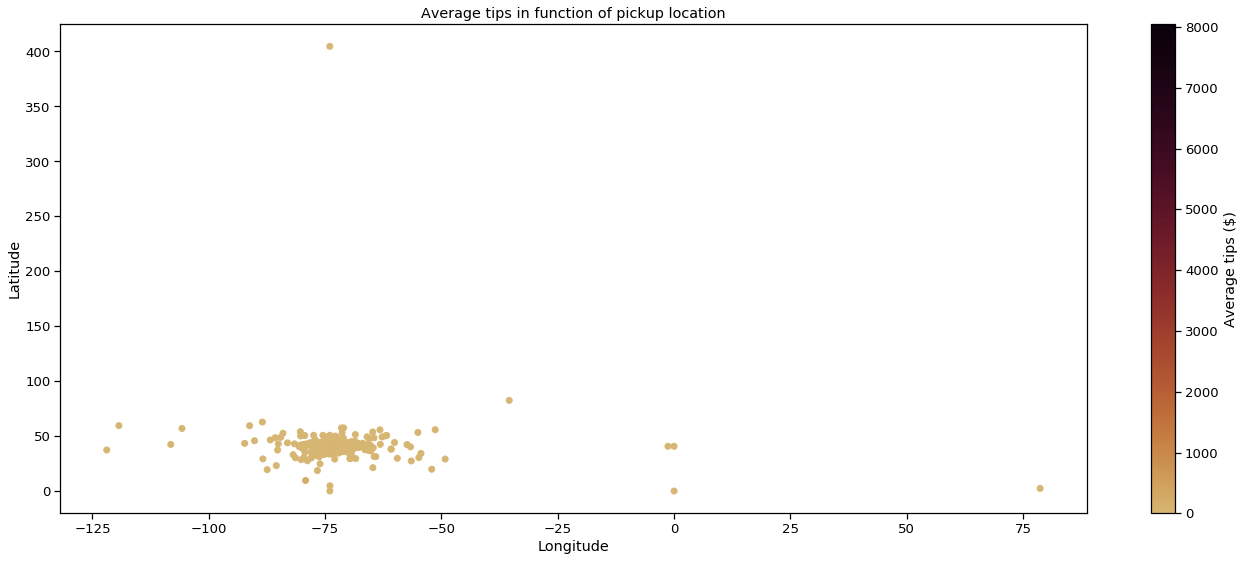

In [34]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

f, ax = plt.subplots(figsize = (23, 9))
tips = ax.scatter(dfp_2015_01_zone_pd.pickup_longitude, 
                  dfp_2015_01_zone_pd.pickup_latitude, 
                  c= dfp_2015_01_zone_pd.average_tip, cmap=cmap)
plt.title("Average tips in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(tips)
cb.set_label("Average tips ($)", labelpad=+5)
plt.show()

Nothing is visible, so we need to zoom where it's crowded.

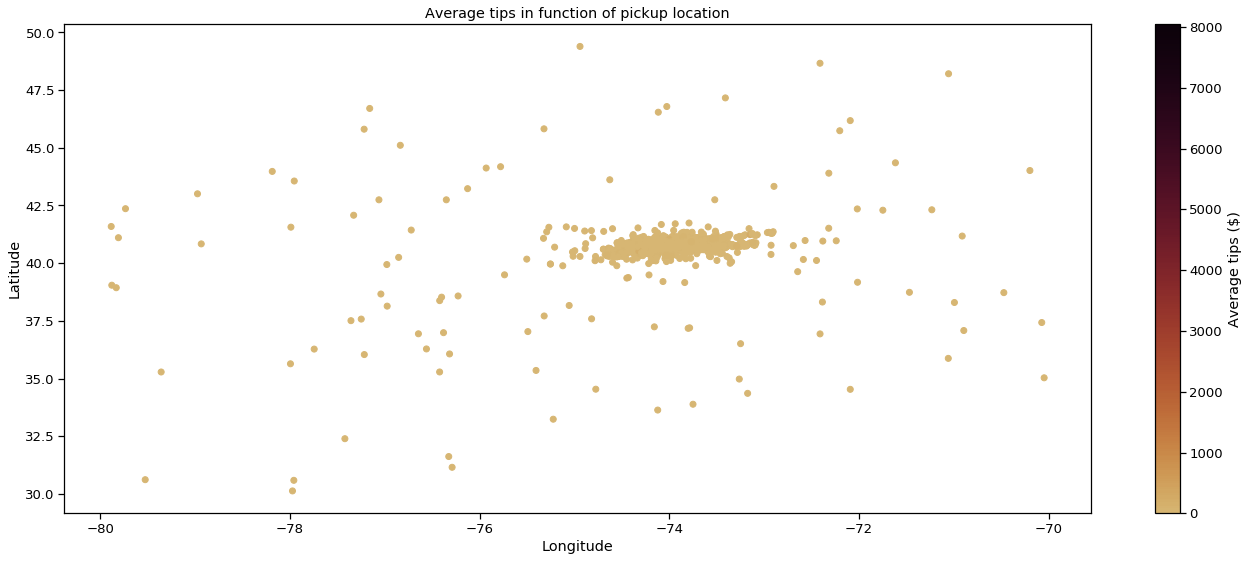

In [35]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-80, -70)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(30,50))]

f, ax = plt.subplots(figsize = (23, 9))
tips = ax.scatter(pd_util.pickup_longitude, 
                  pd_util.pickup_latitude, 
                  c=pd_util.average_tip, cmap=cmap)
plt.title("Average tips in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(tips)
cb.set_label("Average tips ($)", labelpad=+5)
plt.show()

As there are surely not a lot of tips at 8000$, and most of them are surely below 100, we decided to make different plots with different amount ranges; it's similar for the total amount.

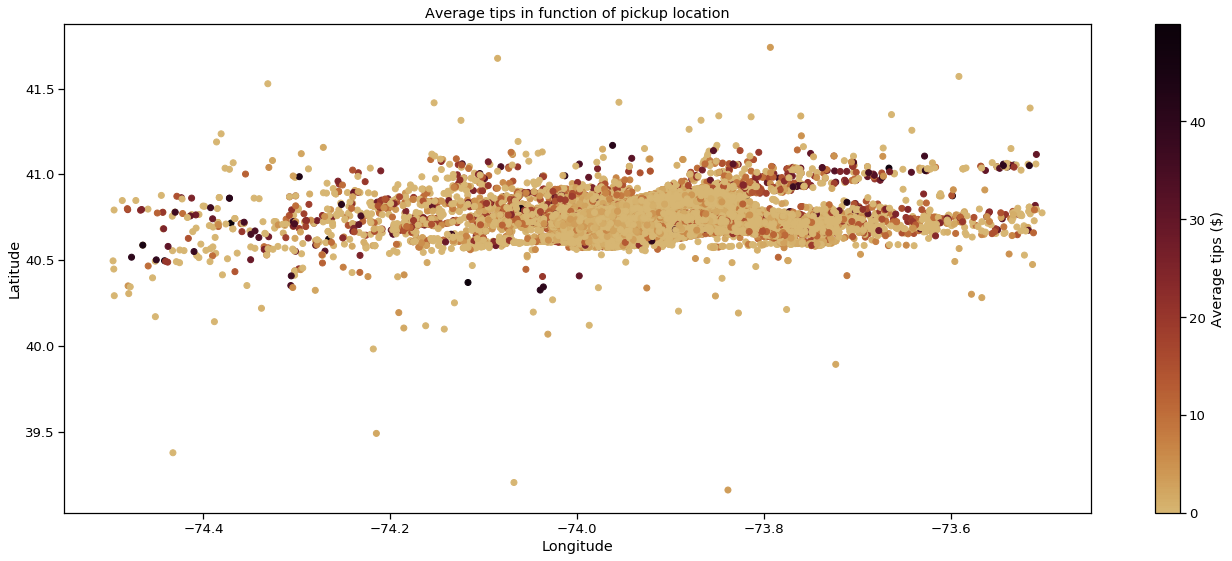

In [36]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-74.5, -73.5)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(39,42)) &\
                              (dfp_2015_01_zone_pd.average_tip < 50)]

f, ax = plt.subplots(figsize = (23, 9))
tips = ax.scatter(pd_util.pickup_longitude, 
                  pd_util.pickup_latitude, 
                  c=pd_util.average_tip, cmap=cmap)
plt.title("Average tips in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(tips)
cb.set_label("Average tips ($)", labelpad=+5)
plt.show()

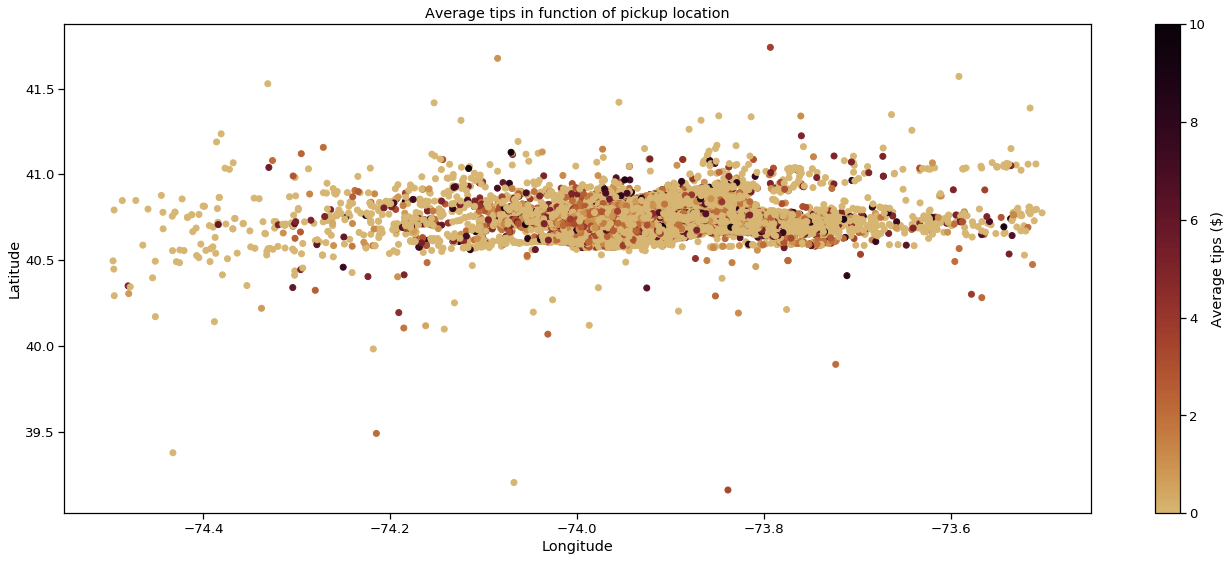

In [37]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-74.5, -73.5)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(39,42)) &\
                              (dfp_2015_01_zone_pd.average_tip < 10)]

f, ax = plt.subplots(figsize = (23, 9))
tips = ax.scatter(pd_util.pickup_longitude, 
                  pd_util.pickup_latitude, 
                  c=pd_util.average_tip, cmap=cmap)
plt.title("Average tips in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(tips)
cb.set_label("Average tips ($)", labelpad=+5)
plt.show()

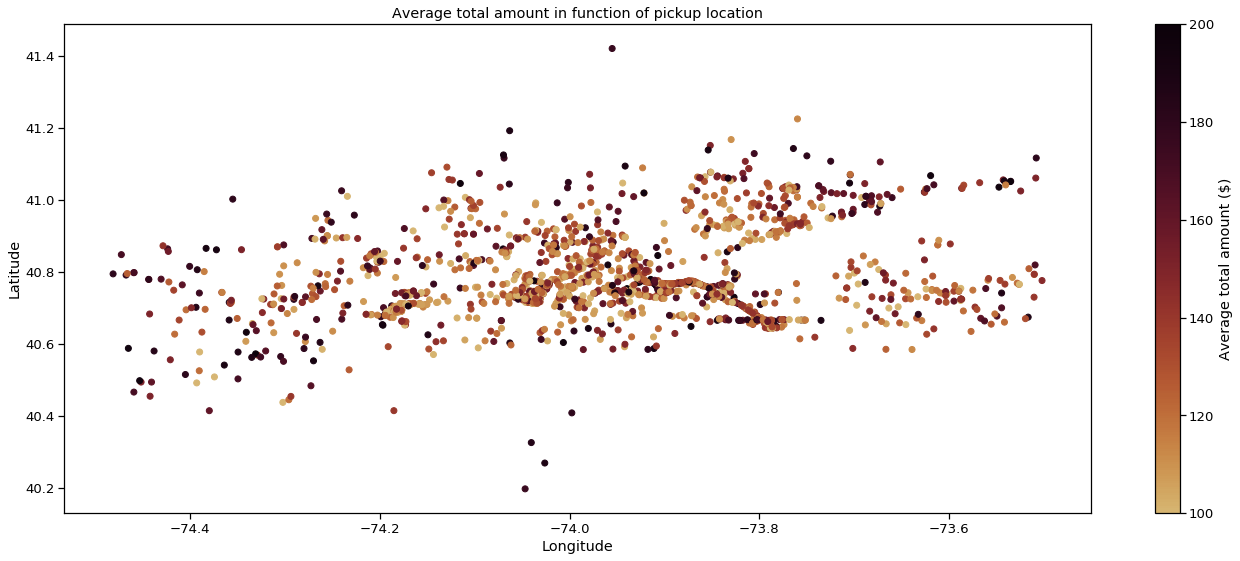

In [38]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-74.5, -73.5)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(39,42)) &\
                              (dfp_2015_01_zone_pd.average_amount.between(100, 200))]

f, ax = plt.subplots(figsize = (23, 9))
profits = ax.scatter(pd_util.pickup_longitude, 
                     pd_util.pickup_latitude, 
                     c=pd_util.average_amount, cmap=cmap)
plt.title("Average total amount in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(profits)
cb.set_label("Average total amount ($)", labelpad=+5)
plt.show()

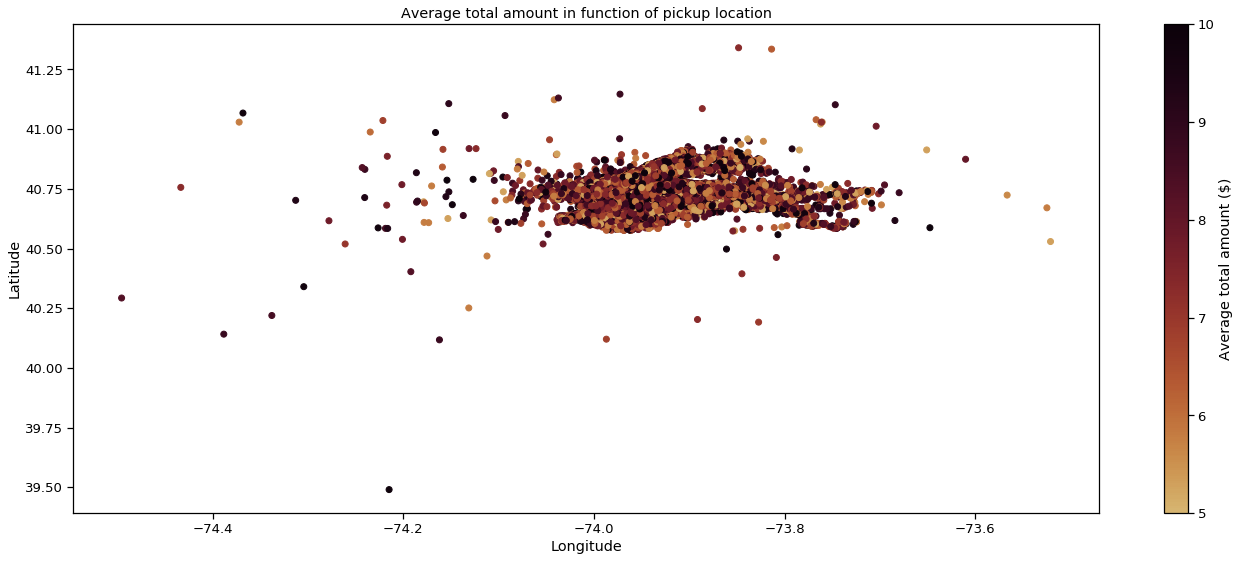

In [39]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-74.5, -73.5)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(39,42)) &\
                              (dfp_2015_01_zone_pd.average_amount.between(5, 10))]

f, ax = plt.subplots(figsize = (23, 9))
profits = ax.scatter(pd_util.pickup_longitude, 
                     pd_util.pickup_latitude, 
                     c=pd_util.average_amount, cmap=cmap)
plt.title("Average total amount in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(profits)
cb.set_label("Average total amount ($)", labelpad=+5)
plt.show()

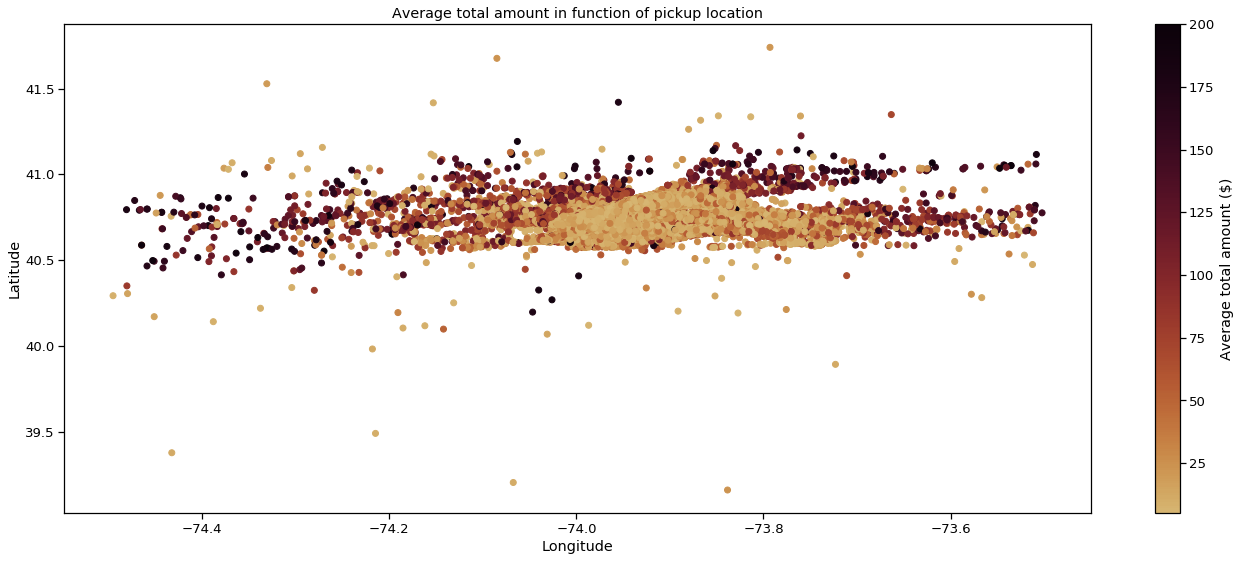

In [40]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-74.5, -73.5)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(39,42)) &\
                              (dfp_2015_01_zone_pd.average_amount.between(5, 200))]

f, ax = plt.subplots(figsize = (23, 9))
profits = ax.scatter(pd_util.pickup_longitude, 
                     pd_util.pickup_latitude, 
                     c=pd_util.average_amount, cmap=cmap)
plt.title("Average total amount in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(profits)
cb.set_label("Average total amount ($)", labelpad=+5)
plt.show()

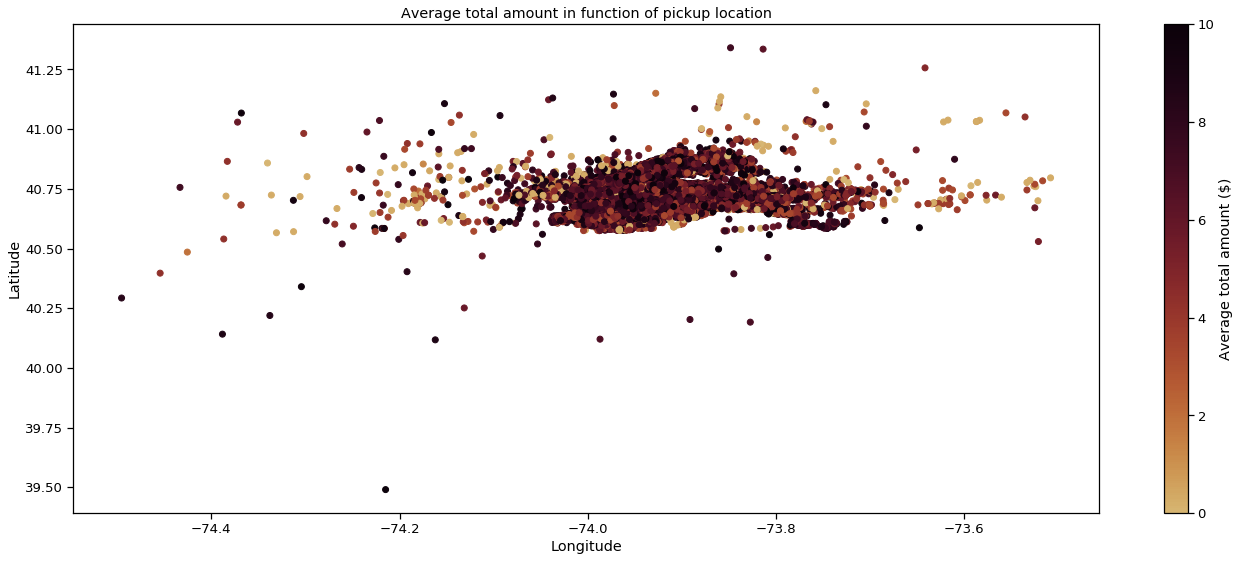

In [41]:
cmap = sns.cubehelix_palette(start = .3,gamma= 2, hue = 1.5, as_cmap=True)

pd_util = dfp_2015_01_zone_pd[(dfp_2015_01_zone_pd.pickup_longitude.between(-74.5, -73.5)) &\
                              (dfp_2015_01_zone_pd.pickup_latitude.between(39,42)) &\
                              (dfp_2015_01_zone_pd.average_amount.between(0, 10))]

f, ax = plt.subplots(figsize = (23, 9))
profits = ax.scatter(pd_util.pickup_longitude, 
                     pd_util.pickup_latitude, 
                     c=pd_util.average_amount, cmap=cmap)
plt.title("Average total amount in function of pickup location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = f.colorbar(profits)
cb.set_label("Average total amount ($)", labelpad=+5)
plt.show()

# Investigate one month of trips data in 2015 and 2018

 Consider one month of trips data from `yellow` taxis for each year

1. Filter and cache/persist the result

## Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

1. The number of pickups
1. The average fare
1. The average trip duration
1. Plot the average number of ongoing trips

## Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitude and magnitudes 
of Manhattan, you can use a service like [geojson.io](http://geojson.io/).
Plot the following time series, indexed the day of the week and hour of the day

1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport
1. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

## Geographic information

For this, you will need to find tools to display maps and to build choropeth maps.
We let you look and find relevant tools to do this.

1. Build a heatmap where color is a function of
    1. number of `pickups`
    2. number of `dropoffs`
    3. number of `pickups` with dropoff at some airport (JFK, LaGuardia, Newark)
2. Build a choropeth map where color is a function of
    1. number of pickups in the area
    1. ratio of number of payments by card/number of cash payments for pickups in the area
    2. ratio of total fare/trip duration for dropoff in the area
3. Build an interactive chorophet with a slider allowing the user to select an `hour of day` and where the color is a function of
    1. average number of dropoffs in the area during that hour the day
    2. average ratio of tip over total fare amount for pickups in the area at given hour of the day

In [9]:
dfp_2015_01.persist()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RatecodeID: int, store_and_fwd_flag: boolean, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double]

In [10]:
dfp_2018_01 = dfp_2018.where(fn.month(col('tpep_pickup_datetime')) == 1)
dfp_2018_01.persist()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, RatecodeID: int, store_and_fwd_flag: boolean, PULocationID: int, DOLocationID: int, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double]

In [15]:
print(dfp_2015_01.is_cached, ' ', dfp_2015_01.is_cached)

True   True


In [12]:
dfp_2015_01_dh = dfp_2015_01.withColumn('pu_dow', fn.date_format('tpep_pickup_datetime', 'EEEE'))\
                            .withColumn('pu_hour', fn.hour('tpep_pickup_datetime'))

In [13]:
dfp_2018_01_dh = dfp_2018_01.withColumn('pu_dow', fn.date_format('tpep_pickup_datetime', 'EEEE'))\
                            .withColumn('pu_hour', fn.hour('tpep_pickup_datetime'))

In [70]:
dfp_2015_01_dhnp = dfp_2015_01_dh.groupBy('pu_dow', 'pu_hour').count()

In [71]:
dfp_2018_01_dhnp = dfp_2018_01_dh.groupBy('pu_dow', 'pu_hour').count()

In [72]:
pd_2015_dhnp = dfp_2015_01_dhnp.toPandas()
pd_2015_dhnp.head()

,pu_dow,pu_hour,count
0,Wednesday,19,116099
1,Wednesday,14,84637
2,Friday,5,20750
3,Wednesday,0,35148
4,Thursday,5,25991


In [73]:
pd_2018_dhnp = dfp_2018_01_dhnp.toPandas()
pd_2018_dhnp.head()

,pu_dow,pu_hour,count
0,Thursday,0,25743
1,Wednesday,0,27359
2,Saturday,13,63803
3,Thursday,5,11325
4,Friday,17,71514


In [48]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

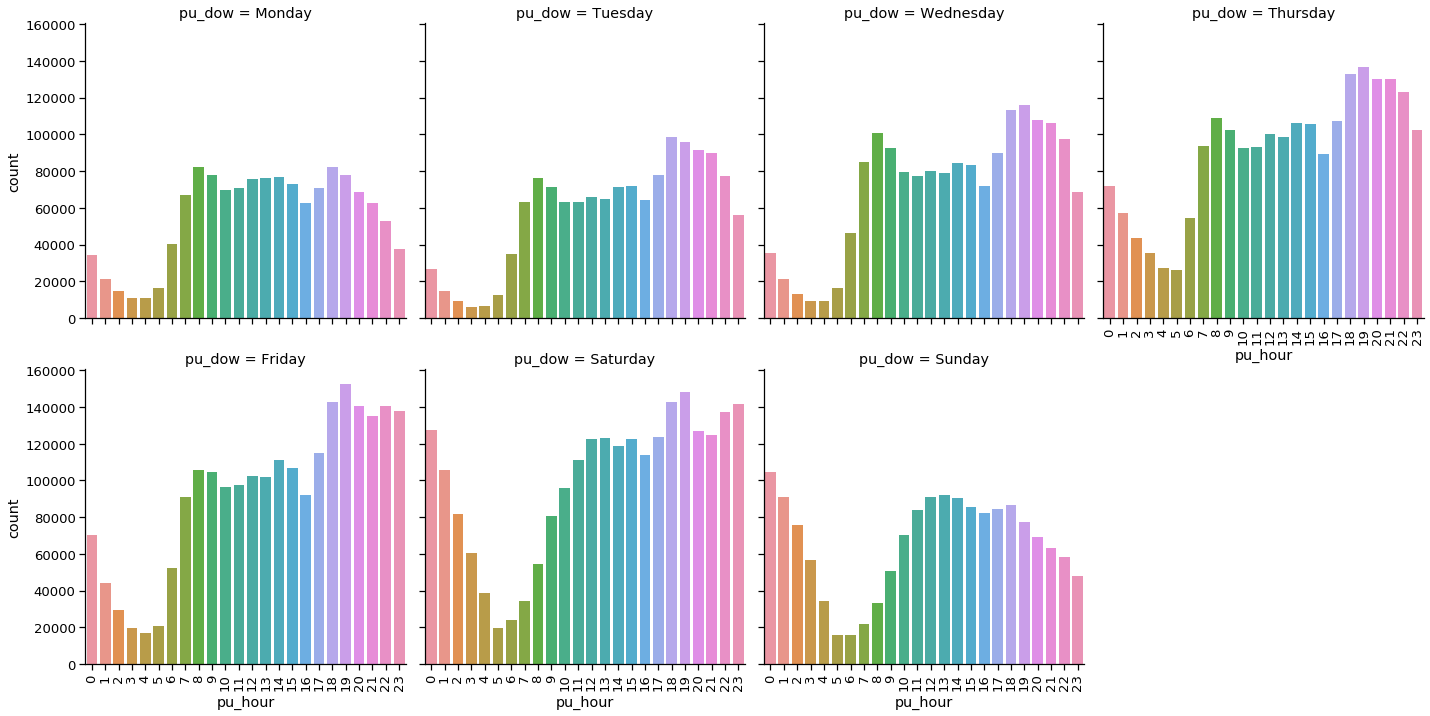

In [75]:
g = sns.catplot(x='pu_hour', y='count', data=pd_2015_dhnp, kind='bar', col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

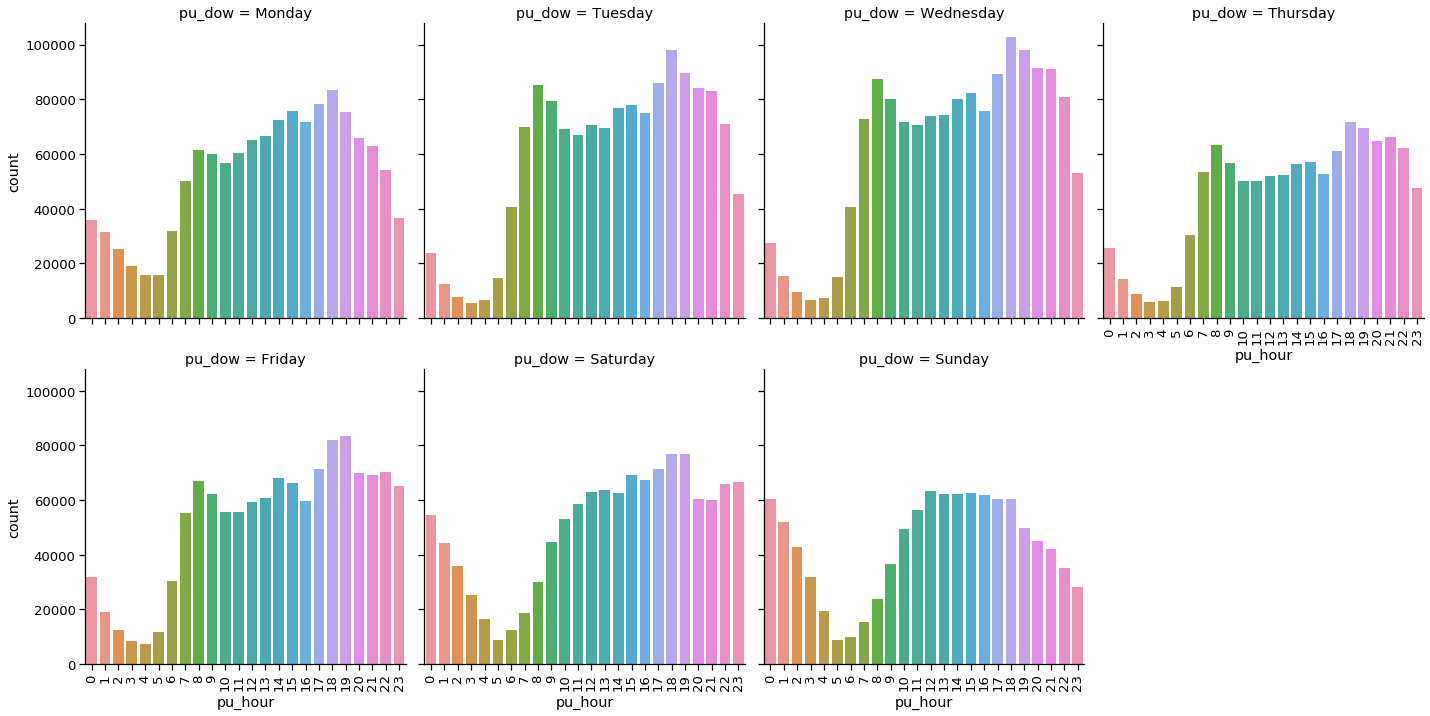

In [76]:
g = sns.catplot(x='pu_hour', y='count', data=pd_2018_dhnp, kind='bar', col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [77]:
dfp_2015_01_dhaf = dfp_2015_01_dh.select('pu_dow', 'pu_hour', 'fare_amount')\
                                 .groupBy('pu_dow', 'pu_hour')\
                                 .agg(fn.mean('fare_amount').alias('average_fare'))

In [78]:
dfp_2018_01_dhaf = dfp_2018_01_dh.select('pu_dow', 'pu_hour', 'fare_amount')\
                                 .groupBy('pu_dow', 'pu_hour')\
                                 .agg(fn.mean('fare_amount').alias('average_fare'))

In [79]:
pd_2015_dhaf = dfp_2015_01_dhaf.toPandas()
pd_2015_dhaf.head()

,pu_dow,pu_hour,average_fare
0,Wednesday,19,10.933613
1,Wednesday,14,12.514285
2,Friday,5,15.863363
3,Wednesday,0,13.075547
4,Thursday,5,14.591701


In [80]:
pd_2018_dhaf = dfp_2018_01_dhaf.toPandas()
pd_2018_dhaf.head()

,pu_dow,pu_hour,average_fare
0,Thursday,0,13.400757
1,Wednesday,0,13.441506
2,Saturday,13,11.705690
3,Thursday,5,13.648964
4,Friday,17,12.622403


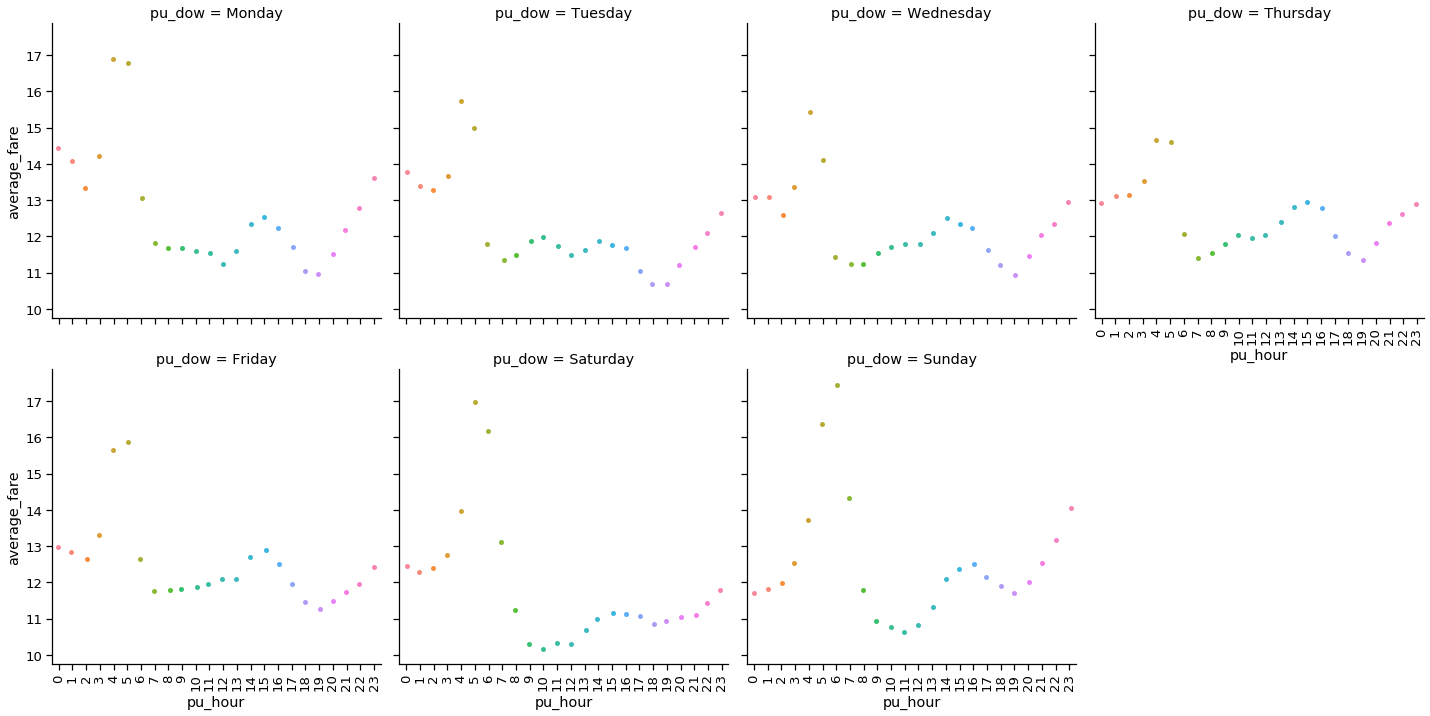

In [81]:
g = sns.catplot(x='pu_hour', y='average_fare', data=pd_2015_dhaf, col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

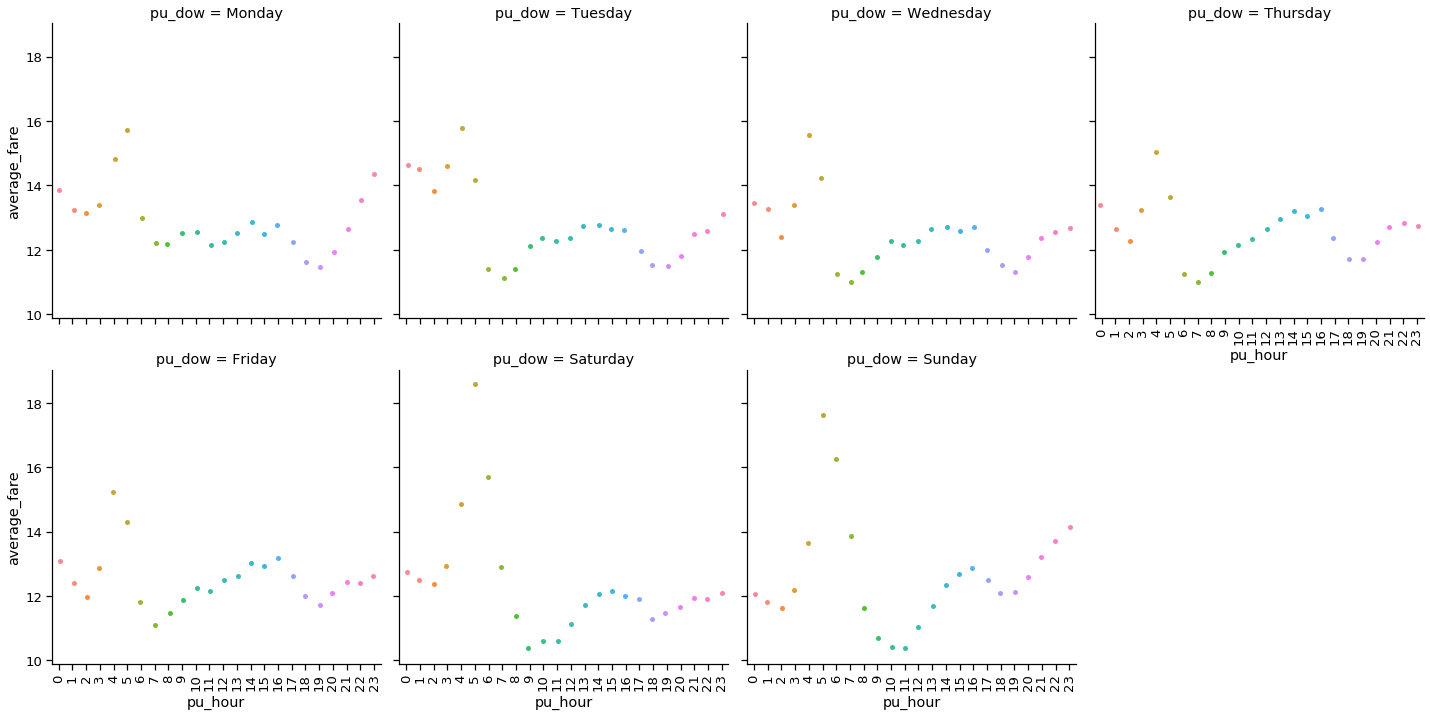

In [82]:
g = sns.catplot(x='pu_hour', y='average_fare', data=pd_2018_dhaf, col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [83]:
dfp_2015_01_dhtd = dfp_2015_01_dh.withColumn('duration', 
                                             (col('tpep_dropoff_datetime').cast('long') - 
                                              col('tpep_pickup_datetime').cast('long')) / 60)\
                                 .select('pu_dow', 'pu_hour', 'duration')\
                                 .groupBy('pu_dow', 'pu_hour')\
                                 .agg(fn.mean('duration').alias('average_duration'))

In [84]:
dfp_2018_01_dhtd = dfp_2018_01_dh.withColumn('duration', 
                                             (col('tpep_dropoff_datetime').cast('long') - 
                                              col('tpep_pickup_datetime').cast('long')) / 60)\
                                 .select('pu_dow', 'pu_hour', 'duration')\
                                 .groupBy('pu_dow', 'pu_hour')\
                                 .agg(fn.mean('duration').alias('average_duration'))

In [85]:
pd_2015_dhtd = dfp_2015_01_dhtd.toPandas()
pd_2015_dhtd.head()

,pu_dow,pu_hour,average_duration
0,Wednesday,19,12.152952
1,Wednesday,14,14.781733
2,Friday,5,13.746415
3,Wednesday,0,12.620331
4,Thursday,5,15.289372


In [86]:
pd_2018_dhtd = dfp_2018_01_dhtd.toPandas()
pd_2018_dhtd.head()

,pu_dow,pu_hour,average_duration
0,Thursday,0,15.314164
1,Wednesday,0,13.312157
2,Saturday,13,15.675201
3,Thursday,5,14.709563
4,Friday,17,18.192888


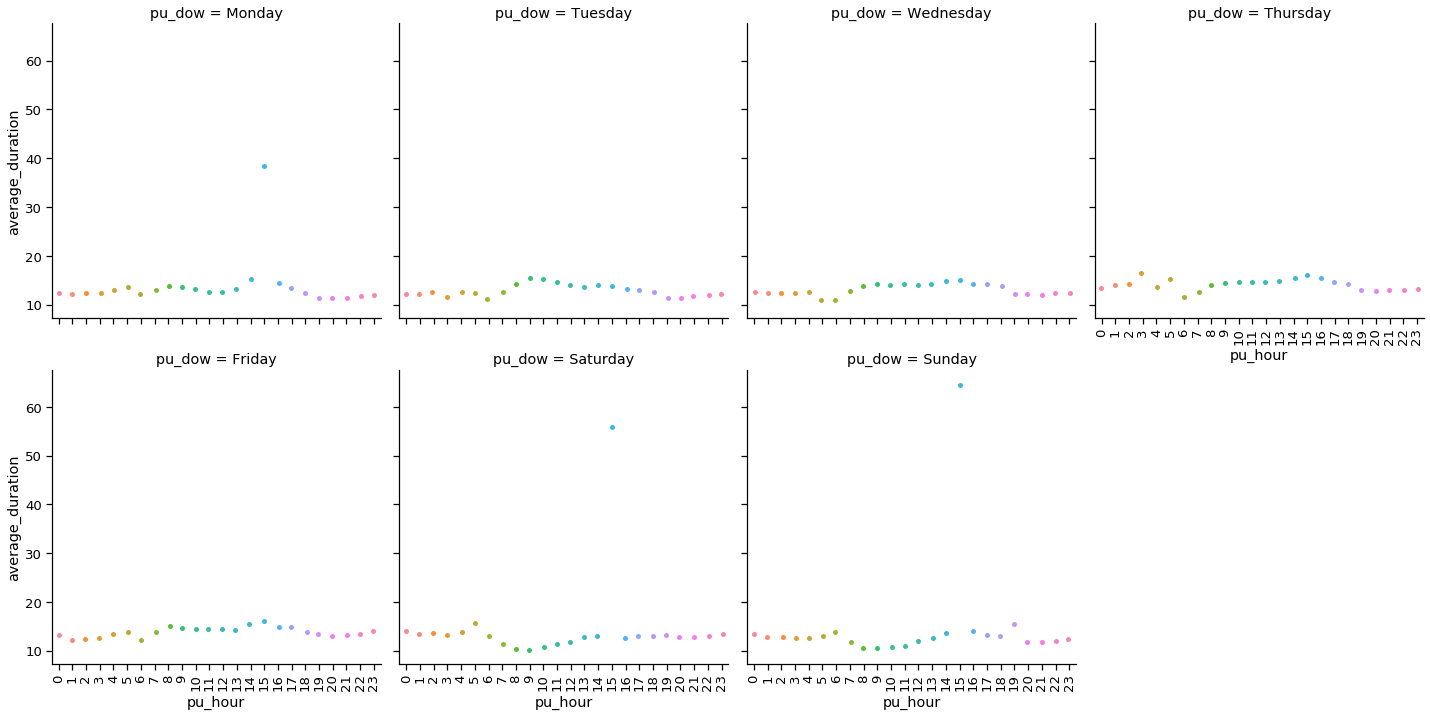

In [87]:
g = sns.catplot(x='pu_hour', y='average_duration', data=pd_2015_dhtd, col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

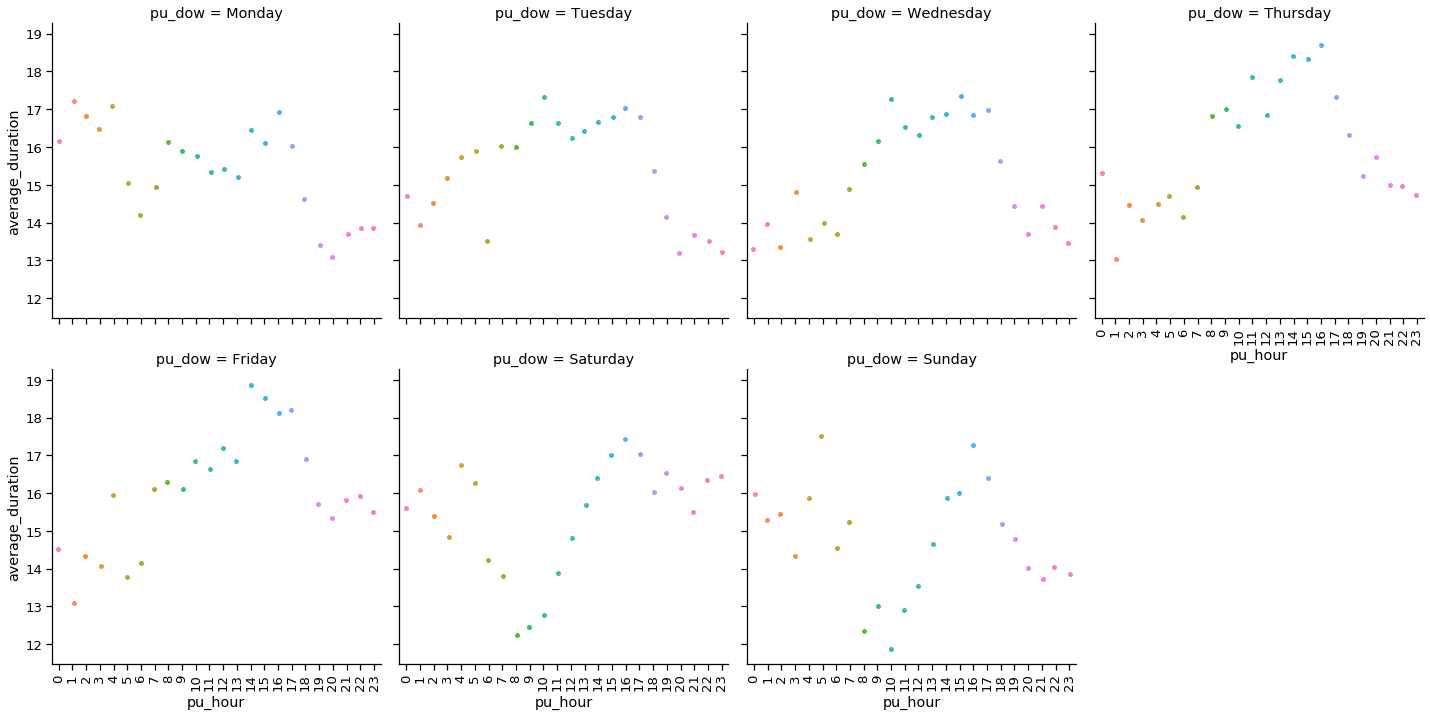

In [88]:
g = sns.catplot(x='pu_hour', y='average_duration', data=pd_2018_dhtd, col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

For the next question, we tried many things... Winodws, UDFs, ... For a very long **long** time... But we failed to answer it in a proper way... So we decided to make a pact with the devil...

In [69]:
def incr_count(num_day, hour):
    return dfp_2015_01_dh.filter(((fn.dayofmonth('tpep_pickup_datetime') < fn.lit(num_day)) | 
                                      (fn.dayofmonth('tpep_pickup_datetime') == fn.lit(num_day)) &\
                                      (fn.hour('tpep_pickup_datetime') <= fn.lit(hour))
                                 ) &\
                                 (
                                     (fn.dayofmonth('tpep_dropoff_datetime') > fn.lit(num_day)) | 
                                     (
                                         (fn.dayofmonth('tpep_dropoff_datetime') == fn.lit(num_day)) &\
                                         (fn.hour('tpep_dropoff_datetime') >= fn.lit(hour))
                                     )
                                 )).count()

In [89]:
res = np.array([])
for i in range(1,36):
    for j in range(0, 24):
        res = np.append(res, incr_count(i,j))

In [132]:
df = spark.createDataFrame(zip(np.repeat(week, 24*5).tolist(), 
                               np.repeat(list(range(1,36)), 24).tolist(), 
                               list(range(0, 24))*7*5,
                               res.astype(int).tolist()),
                           schema=['Day', 'num_day', 'Hour', 'count'])
df.show()

+------+-------+----+-----+
|   Day|num_day|Hour|count|
+------+-------+----+-----+
|Monday|      1|   0|28312|
|Monday|      1|   1|39051|
|Monday|      1|   2|35380|
|Monday|      1|   3|30410|
|Monday|      1|   4|22028|
|Monday|      1|   5|12016|
|Monday|      1|   6| 8377|
|Monday|      1|   7| 7366|
|Monday|      1|   8| 6843|
|Monday|      1|   9| 8166|
|Monday|      1|  10|11376|
|Monday|      1|  11|15993|
|Monday|      1|  12|19280|
|Monday|      1|  13|20648|
|Monday|      1|  14|21514|
|Monday|      1|  15|22025|
|Monday|      1|  16|20311|
|Monday|      1|  17|20909|
|Monday|      1|  18|21717|
|Monday|      1|  19|20177|
+------+-------+----+-----+
only showing top 20 rows



In [134]:
df = df.filter(col('num_day') <= 31)\
       .groupBy('Day', 'Hour')\
       .agg(fn.mean(col('count')).alias('avg'))
df.show()

+---------+----+-------+
|      Day|Hour|    avg|
+---------+----+-------+
|   Monday|   1|19089.2|
|   Monday|   2|15667.6|
|   Monday|   9|14826.0|
|  Tuesday|   0|17300.0|
|  Tuesday|  10|24743.4|
|  Tuesday|  19|36647.8|
|Wednesday|  22|27228.0|
| Thursday|  11|24859.0|
| Thursday|  14|27668.6|
|   Friday|   8|22850.2|
|   Friday|   9|24395.6|
|   Friday|  12|26726.8|
|   Friday|  17|27571.8|
|   Friday|  18|33379.6|
| Saturday|   3| 2785.8|
| Saturday|  12|20225.4|
| Saturday|  18|25569.2|
|   Sunday|  10|26063.0|
|   Sunday|  23|30222.0|
|   Monday|   5| 5941.2|
+---------+----+-------+
only showing top 20 rows



In [135]:
dfpd = df.toPandas()
dfpd.head()

,Day,Hour,avg
0,Monday,1,19089.2
1,Monday,2,15667.6
2,Monday,9,14826.0
3,Tuesday,0,17300.0
4,Tuesday,10,24743.4


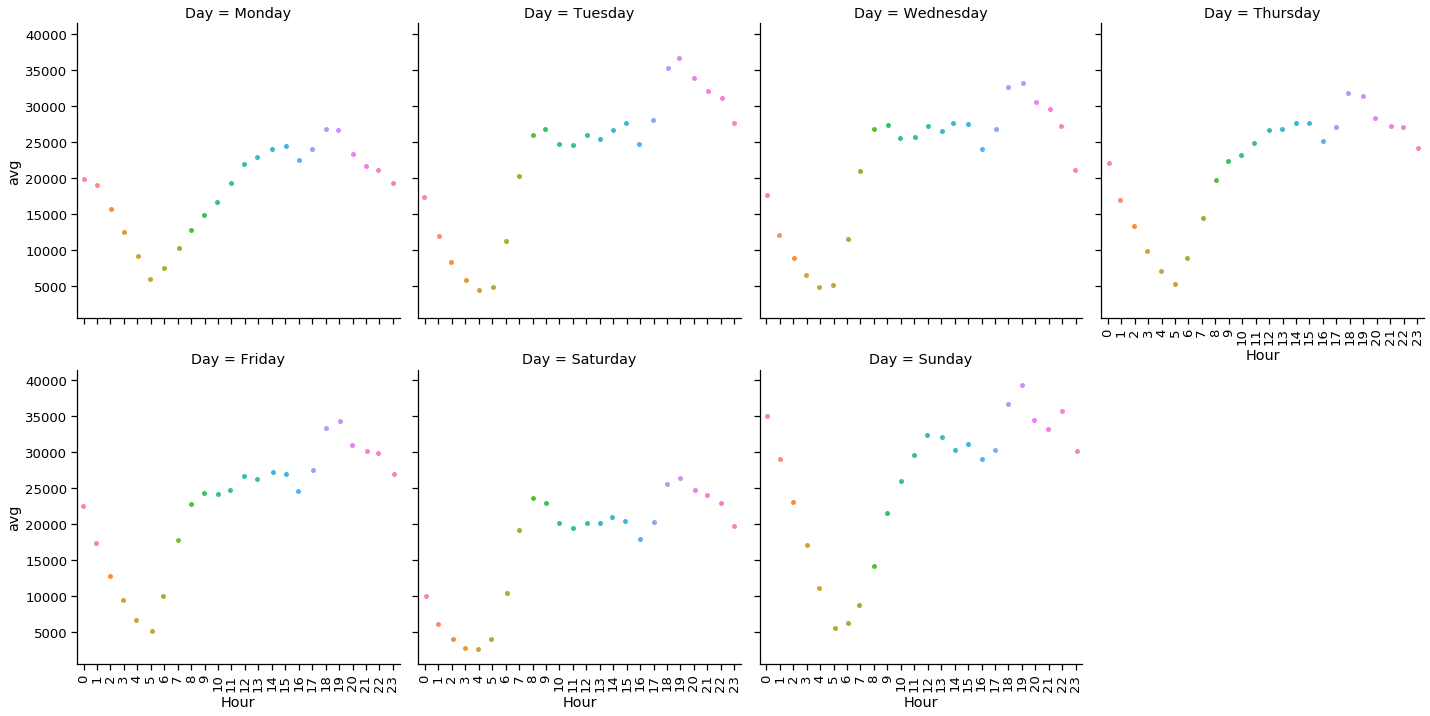

In [136]:
g = sns.catplot(x='Hour', y='avg', data=dfpd, col='Day', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [137]:
def incr_count_2(num_day, hour):
    return dfp_2018_01_dh.filter(((fn.dayofmonth('tpep_pickup_datetime') < fn.lit(num_day)) | 
                                      (fn.dayofmonth('tpep_pickup_datetime') == fn.lit(num_day)) &\
                                      (fn.hour('tpep_pickup_datetime') <= fn.lit(hour))
                                 ) &\
                                 (
                                     (fn.dayofmonth('tpep_dropoff_datetime') > fn.lit(num_day)) | 
                                     (
                                         (fn.dayofmonth('tpep_dropoff_datetime') == fn.lit(num_day)) &\
                                         (fn.hour('tpep_dropoff_datetime') >= fn.lit(hour))
                                     )
                                 )).count()

In [139]:
res2 = np.array([])
for i in range(1,36):
    for j in range(0, 24):
        res2 = np.append(res2, incr_count_2(i,j))

In [140]:
df2 = spark.createDataFrame(zip(np.repeat(week, 24*5).tolist(), 
                                np.repeat(list(range(1,36)), 24).tolist(), 
                                list(range(0, 24))*7*5,
                                res2.astype(int).tolist()),
                            schema=['Day', 'num_day', 'Hour', 'count'])
df2.show()

+------+-------+----+-----+
|   Day|num_day|Hour|count|
+------+-------+----+-----+
|Monday|      1|   0|16714|
|Monday|      1|   1|23597|
|Monday|      1|   2|20852|
|Monday|      1|   3|16096|
|Monday|      1|   4|11427|
|Monday|      1|   5| 5729|
|Monday|      1|   6| 4448|
|Monday|      1|   7| 4439|
|Monday|      1|   8| 4599|
|Monday|      1|   9| 6017|
|Monday|      1|  10| 8264|
|Monday|      1|  11|11693|
|Monday|      1|  12|13783|
|Monday|      1|  13|14356|
|Monday|      1|  14|15047|
|Monday|      1|  15|16113|
|Monday|      1|  16|15659|
|Monday|      1|  17|15745|
|Monday|      1|  18|15043|
|Monday|      1|  19|13484|
+------+-------+----+-----+
only showing top 20 rows



In [141]:
df2 = df2.filter(col('num_day') <= 31)\
         .groupBy('Day', 'Hour')\
         .agg(fn.mean(col('count')).alias('avg'))
df2.show()

+---------+----+-------+
|      Day|Hour|    avg|
+---------+----+-------+
|   Monday|   1| 7507.0|
|   Monday|   2| 6009.0|
|   Monday|   9|13403.6|
|  Tuesday|   0|10283.8|
|  Tuesday|  10|16621.6|
|  Tuesday|  19|21230.4|
|Wednesday|  22|19031.8|
| Thursday|  11|18285.0|
| Thursday|  14|20531.4|
|   Friday|   8|18533.8|
|   Friday|   9|18591.6|
|   Friday|  12|18275.4|
|   Friday|  17|21032.8|
|   Friday|  18|23978.8|
| Saturday|   3| 5940.6|
| Saturday|  12|18793.4|
| Saturday|  18|23832.6|
|   Sunday|  10|19080.0|
|   Sunday|  23|12608.0|
|   Monday|   5| 3681.6|
+---------+----+-------+
only showing top 20 rows



In [143]:
df2pd = df2.toPandas()
df2pd.head()

,Day,Hour,avg
0,Monday,1,7507.0
1,Monday,2,6009.0
2,Monday,9,13403.6
3,Tuesday,0,10283.8
4,Tuesday,10,16621.6


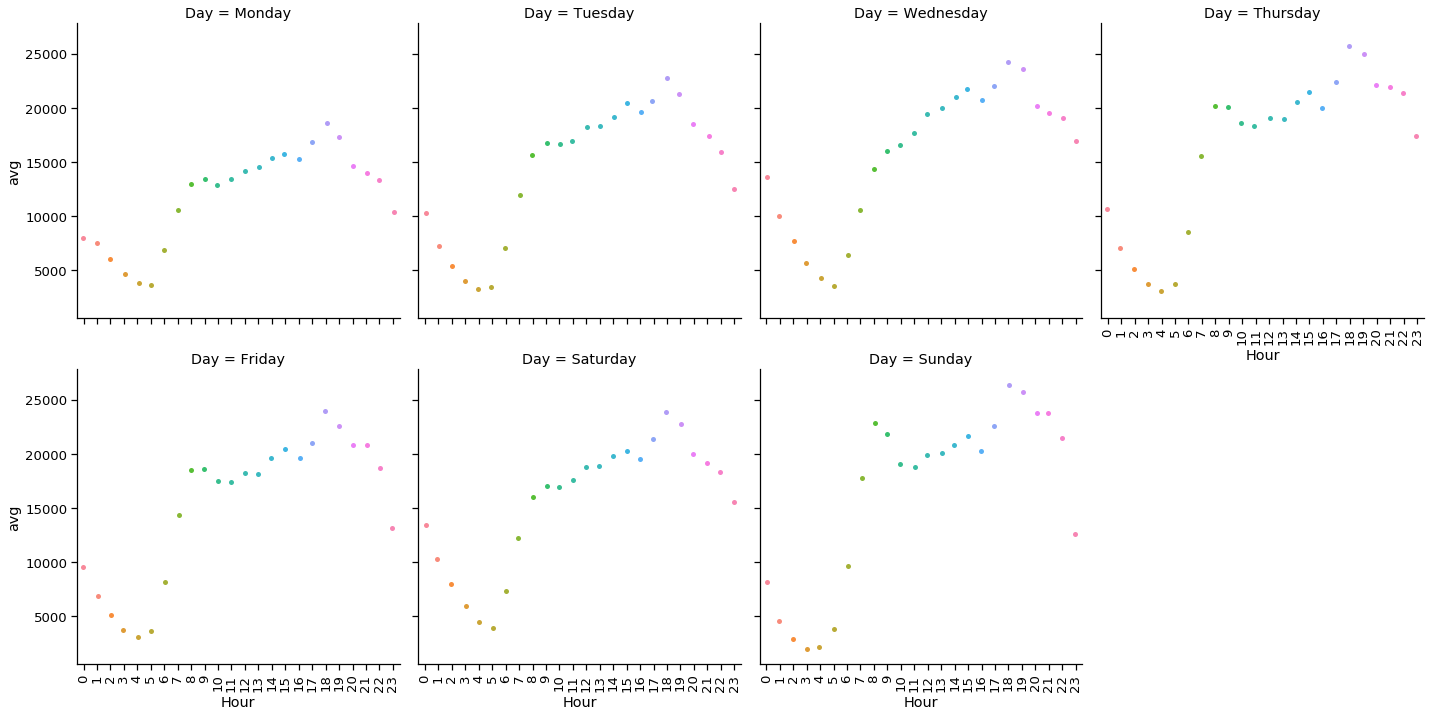

In [144]:
g = sns.catplot(x='Hour', y='avg', data=df2pd, col='Day', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

As it turned out, the performances weren't *that* bad, but we would really appreciate if you could send us a correction to put us back in the right path.

For the next question, here are the coordinates taken using geojson.io

In [145]:
long_maxJFK = -73.7741
long_minJFK = -73.8104
lat_maxJFK = 40.6576
lat_minJFK = 40.6381

long_maxMS = -73.9704
long_minMS = -74.0237
lat_maxMS = 40.7354
lat_minMS = 40.7097

In [146]:
magic_percentile = fn.expr('percentile_approx(duration, 0.5)')

In [150]:
# duration in hours
med_2015 = dfp_2015_01_dh.filter((col('pickup_longitude').between(long_minMS, long_maxMS))&\
                                 (col('pickup_latitude').between(lat_minMS, lat_maxMS)) &\
                                 (col('dropoff_longitude').between(long_minJFK, long_maxJFK)) &\
                                 (col('dropoff_latitude').between(lat_minJFK, lat_maxJFK)))\
                         .withColumn('duration', (col('tpep_dropoff_datetime').cast('long') 
                                                  - col('tpep_pickup_datetime').cast('long')) / 3600)\
                         .groupBy('pu_dow', 'pu_hour')\
                         .agg(magic_percentile.alias('median'))
med_2015.show()

+---------+-------+-------------------+
|   pu_dow|pu_hour|             median|
+---------+-------+-------------------+
|   Friday|      3| 0.4127777777777778|
|   Friday|      5| 0.4533333333333333|
|   Friday|     13| 0.7219444444444445|
|   Friday|     17| 0.8633333333333333|
|   Monday|      3| 0.4022222222222222|
| Saturday|     13| 0.6122222222222222|
|   Sunday|      4| 0.4388888888888889|
|   Sunday|      5|0.42694444444444446|
|   Sunday|      7|0.45166666666666666|
|   Sunday|     12| 0.5138888888888888|
|   Sunday|     14| 0.6655555555555556|
| Thursday|      0| 0.5102777777777778|
| Thursday|      5|0.44055555555555553|
|  Tuesday|     17| 0.9105555555555556|
|  Tuesday|     18|               0.86|
|Wednesday|     14| 0.7705555555555555|
|Wednesday|     17| 0.9797222222222223|
|Wednesday|     19| 0.6744444444444444|
|Wednesday|      0| 0.4816666666666667|
|   Friday|      4| 0.4330555555555556|
+---------+-------+-------------------+
only showing top 20 rows



In [151]:
pdmed_2015 = med_2015.toPandas()
pdmed_2015.head()

,pu_dow,pu_hour,median
0,Friday,3,0.412778
1,Friday,5,0.453333
2,Friday,13,0.721944
3,Friday,17,0.863333
4,Monday,3,0.402222


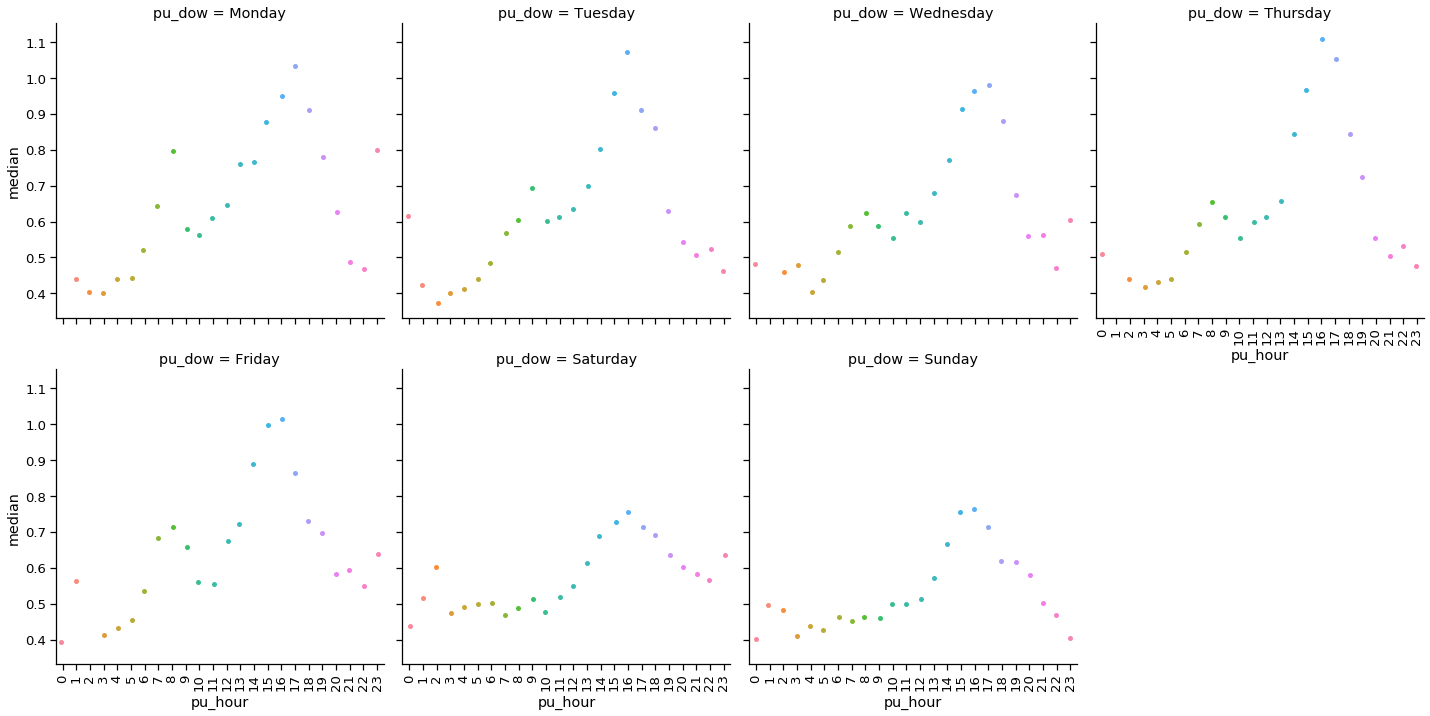

In [153]:
g = sns.catplot(x='pu_hour', y='median', data=pdmed_2015, col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [154]:
medJFKMid_2015 = dfp_2015_01_dh.filter((col('dropoff_longitude').between(long_minMS, long_maxMS))&\
                                       (col('dropoff_latitude').between(lat_minMS, lat_maxMS)) &\
                                       (col('pickup_longitude').between(long_minJFK, long_maxJFK)) &\
                                       (col('pickup_latitude').between(lat_minJFK, lat_maxJFK)))\
                               .withColumn('duration', (col('tpep_dropoff_datetime').cast('long') 
                                                  - col('tpep_pickup_datetime').cast('long')) / 3600)\
                               .groupBy('pu_dow', 'pu_hour')\
                               .agg(magic_percentile.alias('median'))
medJFKMid_2015.show()

+---------+-------+-------------------+
|   pu_dow|pu_hour|             median|
+---------+-------+-------------------+
|   Friday|      3|0.44722222222222224|
|   Friday|      5| 0.6180555555555556|
|   Friday|     13| 0.7441666666666666|
|   Friday|     17| 0.8636111111111111|
|   Monday|      0| 0.4502777777777778|
|   Monday|      3| 0.4066666666666667|
| Saturday|     13| 0.6502777777777777|
|   Sunday|      4|0.43416666666666665|
|   Sunday|      5|0.46166666666666667|
|   Sunday|      7| 0.4777777777777778|
|   Sunday|     12| 0.5952777777777778|
|   Sunday|     14| 0.8047222222222222|
| Thursday|      0| 0.4636111111111111|
| Thursday|      5| 0.5858333333333333|
|  Tuesday|     17| 0.8538888888888889|
|  Tuesday|     18| 0.7063888888888888|
|Wednesday|      0|0.48194444444444445|
|Wednesday|     14| 0.7663888888888889|
|Wednesday|     17|             0.8525|
|Wednesday|     19|             0.5875|
+---------+-------+-------------------+
only showing top 20 rows



In [155]:
pdmedJFKMid_2015 = medJFKMid_2015.toPandas()
pdmedJFKMid_2015.head()

,pu_dow,pu_hour,median
0,Friday,3,0.447222
1,Friday,5,0.618056
2,Friday,13,0.744167
3,Friday,17,0.863611
4,Monday,0,0.450278


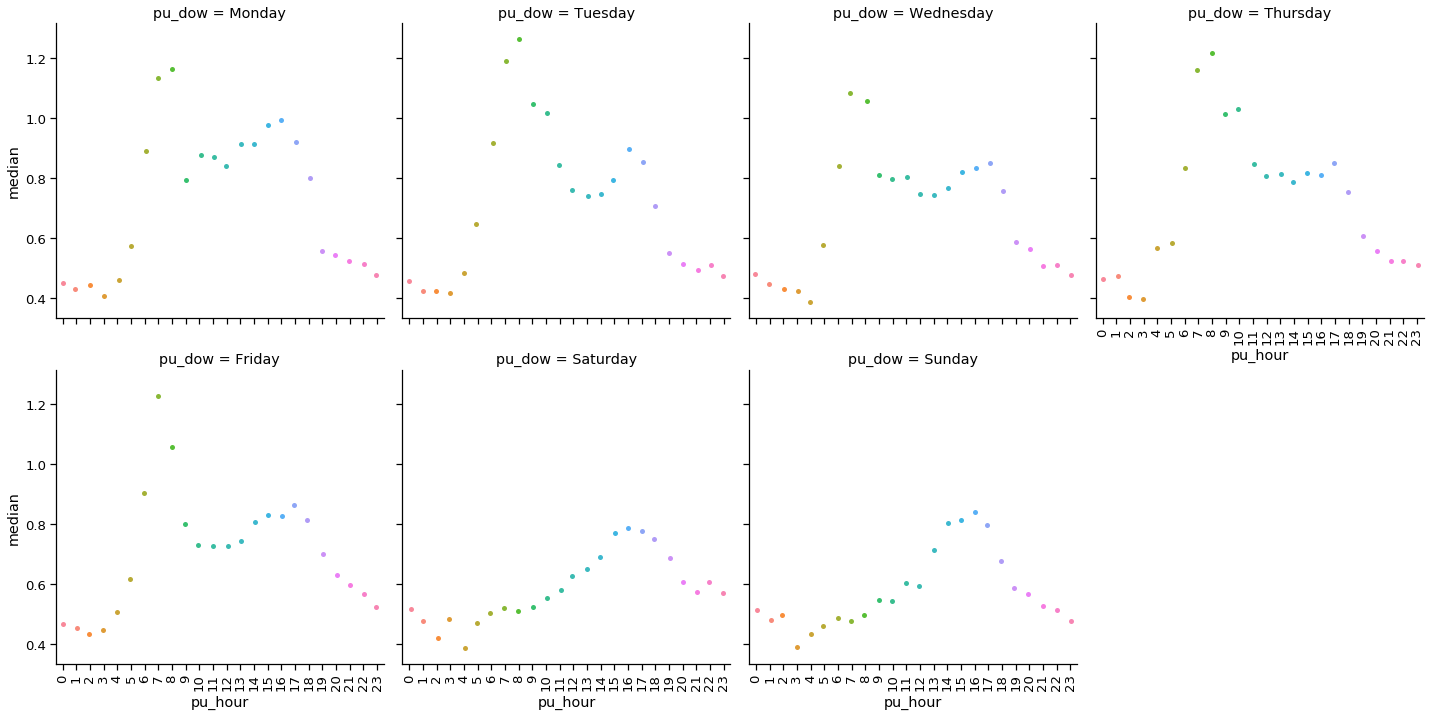

In [156]:
g = sns.catplot(x='pu_hour', y='median', data=pdmedJFKMid_2015, col='pu_dow', col_wrap=4, col_order=week)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [158]:
spark.stop()